[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/psn-ibs/blob/main/notebooks/patient_similarity_networks_ibs_brain_morphometry_cognition.ipynb)


Version 2025-12-26,  A. Lundervold

# Patient Similarity Networks for Irritable Bowel Syndrome: Revisiting Brain Morphometry and Cognitive Features

**A computational research project based on data from [Lundervold et al. (2025)](https://doi.org/10.3390/diagnostics15040470)**

---

This notebook demonstrates how **Patient Similarity Networks (PSN)** can be applied to explore heterogeneity in a clinical population with Irritable Bowel Syndrome (IBS). We combine brain morphometric measures from MRI examinations with cognitive tests to construct networks that reveal patient subgroups and important clinical features.

**Key contributions:**
- Network-based analysis complementing the machine learning approach in the original study
- Multiple similarity measures and sensitivity analyses
- Statistical validation with bootstrap and permutation testing
- Comparison with hierarchical clustering methods


---

## Abstract

**Background:** Irritable Bowel Syndrome (IBS) is a heterogeneous gastrointestinal disorder characterized by complex brain-gut interactions. Patient Similarity Networks (PSN) offer a novel approach for exploring this heterogeneity and identifying clinically relevant patient subgroups.

**Methods:** We analyzed data from 78 participants (49 IBS patients and 29 healthy controls) with 36 brain morphometric measures (FreeSurfer v7.4.1) and six measures of cognitive functions (five RBANS domain indices plus a Total Scale score). PSN were constructed using multiple similarity measures (Euclidean, cosine, correlation-based) with Gaussian kernel transformation. We performed community detection (Louvain algorithm), centrality analyses, feature importance analysis, and correlations with symptom severity. Statistical validation included bootstrap confidence intervals and permutation testing.

**Results:** The PSN comprised 78 nodes connected by 469 edges, with four communities detected. These communities did not significantly correspond to diagnostic groups (Adjusted Rand Index = 0.011, permutation p = 0.212), indicating IBS patients and healthy controls were intermixed. However, each community exhibited distinct neurobiological profiles: Community 1 (oldest, preserved cognition) showed elevated intracranial volume but reduced subcortical gray matter; Community 2 (youngest, most severe IBS symptoms) had elevated cortical volumes but reduced white matter; Community 3 (most balanced IBS/HC ratio, mildest IBS symptoms) showed the largest subcortical volumes; Community 4 (lowest cognitive performance across multiple domains) displayed the lowest RBANS scores alongside high IBS prevalence. Top network features included subcortical structures, corpus callosum, and cognitive indices (Language, Attention).

**Conclusions:** PSN identifies brain-cognition subgroups that cut across diagnostic categories, with distinct feature profiles suggesting different neurobiological phenotypes within IBS that may inform personalized treatment strategies.

**Keywords:** irritable bowel syndrome, patient similarity networks, brain morphometry, cognition, RBANS, FreeSurfer, community detection, network analysis, gut-brain axis


---

## 1. Introduction

### 1.1 Background and Motivation

**Irritable Bowel Syndrome (IBS)** is one of the most prevalent disorders of gut-brain interaction, affecting approximately 10% of the global population [1]. The syndrome is characterized by recurrent abdominal pain associated with defecation, accompanied by alterations in bowel habits [2]. The clinical presentation is heterogeneous, with symptoms ranging from mild discomfort to severe complaints that substantially impair quality of life and daily functioning [3].

IBS is now recognized as a **gut-brain disorder**, where bidirectional interactions between gastrointestinal symptoms and psychological/cognitive function play a central role [4]. While GI symptoms can trigger or exacerbate psychological distress, anxiety and depression can in turn worsen the frequency and intensity of abdominal pain [5].

Recent research has expanded this psychobiological framework to include **cognitive function**, revealing a more nuanced picture of brain-gut interactions in IBS [6]. Although cognitive impairments have been demonstrated at the group level, these deficits appear to characterize specific subgroups rather than being a universal feature of IBS.

### 1.2 Patient Similarity Networks as an Analytical Approach

**Patient Similarity Networks (PSN)** represent a powerful methodology for exploring heterogeneity in clinical populations [7]. In a PSN:

- Each **node** represents a patient
- **Edges** connect patients who are similar based on clinical/biological variables
- **Edge weights** reflect the degree of similarity between patients

This network approach enables:
1. Identification of natural patient groups (communities) without predefined categories
2. Finding "central" patients who are representative of their group
3. Discovering which clinical features drive patient similarity
4. Relating network structure to clinical outcomes

### 1.3 The Original Study

This work builds upon Lundervold et al. (2025) [8], who studied brain morphometry and cognitive features for IBS prediction using machine learning approaches (XGBoost, Random Forest). Their key findings included:
- Combining morphometric and cognitive measures achieved 93% sensitivity in identifying IBS patients
- Subcortical structures (hippocampus, caudate, putamen) and cognitive domains (Delayed Memory, Language) were important for group discrimination
- FreeSurfer version comparison revealed substantial variations in morphometric measurements

Our PSN approach complements their machine learning analysis by providing:
- Visual representation of patient relationships
- Identification of natural subgroups without supervised learning
- Insights into heterogeneity within diagnostic groups

### 1.4 Research Questions

In this study, we apply PSN to data from an IBS cohort to address the following questions:

1. **Can PSN identify meaningful subgroups** among IBS patients and healthy controls based on brain morphometry and cognitive measures?

2. **Which brain and cognitive features** drive similarity between patients in the network?

3. **Does network structure differ** between IBS patients and healthy controls?

4. **How do network properties** (e.g., centrality) relate to symptom severity (IBS-SSS)?

5. **How robust are the findings** across different similarity measures and parameter choices?

### 1.5 Study Objectives

The objectives of this notebook are to:

- Construct and visualize PSN from real clinical data
- Compare multiple similarity measures (Euclidean, cosine, correlation)
- Perform community detection and evaluate against known groups
- Analyze centrality and identify key patients
- Compare network properties between IBS and controls
- Identify the most important features driving network structure
- Investigate clinical correlations with symptom severity
- Validate findings with bootstrap and permutation testing
- Compare with hierarchical clustering approaches


---

## 2. Methods

### 2.1 Study Population and Data

The dataset is derived from the study by Lundervold et al. (2025) [8] and includes:

- **78 participants**: 49 IBS patients and 29 healthy controls (HC)
- **Brain morphometry**: Volumetric measures from FreeSurfer v7.4.1 processing of structural MR images
- **Cognitive measures**: Index scores from RBANS (Repeatable Battery for the Assessment of Neuropsychological Status)
- **Clinical data**: IBS-SSS (IBS Severity Scoring System), demographic variables

**Variables included:**
- Subcortical volumes (normalized to eTIV): thalamus, caudate, putamen, pallidum, hippocampus, amygdala, nucleus accumbens
- Cerebellum volumes (white and gray matter)
- Corpus callosum segments
- Cerebral white matter and cortex volumes
- RBANS indices: Total Scale, Immediate Memory, Visuospatial/Constructional, Language, Attention, Delayed Memory
- IBS-SSS: Symptom severity score (0-500)

### 2.2 Setup and Data Loading


In [1]:
# ============================================================
# SETUP - Run this cell first!
# ============================================================

import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Sklearn for preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering

# Scipy for distance calculations and statistics
from scipy.spatial.distance import pdist, squareform, cosine
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats

# Community detection
import community.community_louvain as community_louvain

# Seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Color scheme for groups
GROUP_COLORS = {'IBS': '#E63946', 'HC': '#457B9D'}

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# ============================================================
# Load Data
# ============================================================

def setup_data_path():
    """Set up correct data path for both local execution and Colab"""
    try:
        from google.colab import drive
        # If in Colab, download data from GitHub
        !mkdir -p data
        !wget -q -O data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv \
            https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        return 'data'
    except:
        # Local execution - use relative path
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

# Set up data path and load data
data_path = setup_data_path()
data_file = os.path.join(data_path, 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv')

df = pd.read_csv(data_file)

print(f"Data loaded: {df.shape[0]} participants, {df.shape[1]} variables")
print(f"\nGroup distribution:")
print(df['Group'].value_counts())


Data loaded: 78 participants, 48 variables

Group distribution:
Group
IBS    49
HC     29
Name: count, dtype: int64


### 2.3 Data Preprocessing

To construct meaningful patient similarity networks, we:

1. **Select relevant features**: Numerical variables representing brain morphometry and cognition
2. **Handle missing values**: Imputation with column means
3. **Standardize**: Z-score transformation so all features contribute equally to similarity calculation

$$z_i = \frac{x_i - \mu}{\sigma}$$

This ensures that variables with different scales (e.g., brain volumes vs. cognitive scores) are weighted equally.


In [3]:
# ============================================================
# Data Preprocessing
# ============================================================

# Define feature groups for later analysis
MORPHOMETRY_COLS = [col for col in df.columns if col not in 
                   ['Subject', 'Group', 'Age', 'Gender', 'Education', 
                    'Fullscale_RBANS', 'Memory_Index', 'Visuospatial_Index', 
                    'Verbalskills_Index', 'Attention_Index', 'Recall_Index', 'IBS_SSS']]

COGNITIVE_COLS = ['Fullscale_RBANS', 'Memory_Index', 'Visuospatial_Index', 
                  'Verbalskills_Index', 'Attention_Index', 'Recall_Index']

# All numerical features for network construction (excluding IBS_SSS for independent analysis)
FEATURE_COLS = MORPHOMETRY_COLS + COGNITIVE_COLS

print(f"Brain morphometric features: {len(MORPHOMETRY_COLS)}")
print(f"Cognitive features: {len(COGNITIVE_COLS)}")
print(f"Total features for PSN: {len(FEATURE_COLS)}")

# Feature name mapping: data column names -> official RBANS names (Randolph, 1998)
FEATURE_DISPLAY_NAMES = {
    # RBANS cognitive indices
    'Fullscale_RBANS': 'Total Scale',
    'Memory_Index': 'Immediate Memory',
    'Visuospatial_Index': 'Visuospatial/Constructional',
    'Verbalskills_Index': 'Language',
    'Attention_Index': 'Attention',
    'Recall_Index': 'Delayed Memory',
}

def get_display_name(col_name):
    """Convert data column name to display name for figures."""
    return FEATURE_DISPLAY_NAMES.get(col_name, col_name.replace('_', ' ').replace('-', ' '))

# Extract metadata
subjects = df['Subject'].values
groups = df['Group'].values
ibs_sss = df['IBS_SSS'].values

# Extract features
X_raw = df[FEATURE_COLS].values

# Handle missing values with mean imputation
X_imputed = pd.DataFrame(X_raw, columns=FEATURE_COLS).fillna(
    pd.DataFrame(X_raw, columns=FEATURE_COLS).mean()
).values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Convert groups to numeric for evaluation
group_numeric = np.array([0 if g == 'IBS' else 1 for g in groups])

print(f"\nPreprocessing complete!")
print(f"  - Data shape: {X_scaled.shape}")
print(f"  - Missing values handled: {np.isnan(X_raw).sum()}")
print(f"  - Features standardized (mean~0, std~1)")


Brain morphometric features: 36
Cognitive features: 6
Total features for PSN: 42

Preprocessing complete!
  - Data shape: (78, 42)
  - Missing values handled: 0
  - Features standardized (mean~0, std~1)


### 2.4 Network Construction Methods

We construct PSN using multiple similarity measures to assess robustness:

**Step 1: Compute pairwise distances**

Three distance/similarity metrics:
- **Euclidean distance**: $d_{ij} = \sqrt{\sum_{k=1}^{p} (x_{ik} - x_{jk})^2}$ -- measures straight-line distance; sensitive to absolute differences
- **Cosine distance**: $d_{ij} = 1 - \frac{\mathbf{x}_i \cdot \mathbf{x}_j}{\|\mathbf{x}_i\| \|\mathbf{x}_j\|}$ -- measures the angle between feature vectors; vectors pointing in similar directions have low cosine distance regardless of magnitude
- **Correlation distance**: $d_{ij} = 1 - \rho(\mathbf{x}_i, \mathbf{x}_j)$ -- measures how features co-vary together

**Illustrative example**: Consider two participants who both show relatively larger hippocampal volumes, smaller amygdala volumes, and higher memory scores, but one has generally larger brain structures overall. Euclidean distance would rate them as dissimilar due to the absolute size differences, whereas cosine distance would recognize their similar neuroanatomical-cognitive "signature" and rate them as similar. The following cell demonstrates this with a numerical example.

**Step 2: Transform to similarity using Gaussian kernel**

$$s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)$$

where $\sigma$ is set to the mean distance for normalization.

**Step 3: Apply k-nearest-neighbor (k-NN) and threshold**

To avoid overly dense networks, we combine:
- Connect each node to its k nearest neighbors
- Remove edges with similarity below threshold

---

## 3. Results

### 3.1 Network Construction and Basic Structure


In [4]:
# ============================================================
# Illustrative Example: Euclidean vs Cosine Distance
# ============================================================
# Demonstrate how these metrics capture different aspects of similarity

import numpy as np
from scipy.spatial.distance import euclidean, cosine

# Simulated feature values for three participants
# Features: [Hippocampus_L, Hippocampus_R, Amygdala_L, Amygdala_R, Memory_Score]
# (using standardized z-scores for illustration)

# Participant A: baseline pattern
participant_A = np.array([0.8, 0.7, -0.5, -0.4, 1.2])  # larger hippo, smaller amygdala, high memory

# Participant B: SAME PATTERN but scaled up (generally larger brain)
participant_B = np.array([1.6, 1.4, -0.3, -0.2, 1.5])  # proportionally similar pattern

# Participant C: DIFFERENT PATTERN (opposite profile)
participant_C = np.array([-0.6, -0.5, 0.8, 0.7, -0.8])  # smaller hippo, larger amygdala, low memory

print("=" * 70)
print("DISTANCE METRIC COMPARISON: Pattern vs Absolute Differences")
print("=" * 70)
print("\nFeatures: [Hippo_L, Hippo_R, Amygdala_L, Amygdala_R, Memory]")
print(f"\nParticipant A (baseline):     {participant_A}")
print(f"Participant B (scaled-up A):  {participant_B}")
print(f"Participant C (opposite):     {participant_C}")

# Calculate distances
print("\n" + "-" * 70)
print("EUCLIDEAN DISTANCE (sensitive to absolute magnitude):")
print("-" * 70)
euc_AB = euclidean(participant_A, participant_B)
euc_AC = euclidean(participant_A, participant_C)
print(f"  A vs B (same pattern, different magnitude): {euc_AB:.3f}")
print(f"  A vs C (different pattern):                 {euc_AC:.3f}")
print(f"  → Euclidean says A is MORE SIMILAR to {'B' if euc_AB < euc_AC else 'C'}")

print("\n" + "-" * 70)
print("COSINE DISTANCE (focuses on pattern/direction):")
print("-" * 70)
cos_AB = cosine(participant_A, participant_B)
cos_AC = cosine(participant_A, participant_C)
print(f"  A vs B (same pattern, different magnitude): {cos_AB:.3f}")
print(f"  A vs C (different pattern):                 {cos_AC:.3f}")
print(f"  → Cosine says A is MORE SIMILAR to {'B' if cos_AB < cos_AC else 'C'}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("""
• Euclidean distance rates A & B as quite different because their absolute 
  values differ, even though they share the same neuroanatomical-cognitive 
  'signature' (larger hippocampus, smaller amygdala, higher memory).

• Cosine distance recognizes that A & B point in the same 'direction' in 
  feature space (small angle between vectors) and rates them as highly 
  similar despite the magnitude differences.

• For patient similarity networks, using multiple metrics helps capture 
  different aspects of similarity and assess robustness of findings.
""")

DISTANCE METRIC COMPARISON: Pattern vs Absolute Differences

Features: [Hippo_L, Hippo_R, Amygdala_L, Amygdala_R, Memory]

Participant A (baseline):     [ 0.8  0.7 -0.5 -0.4  1.2]
Participant B (scaled-up A):  [ 1.6  1.4 -0.3 -0.2  1.5]
Participant C (opposite):     [-0.6 -0.5  0.8  0.7 -0.8]

----------------------------------------------------------------------
EUCLIDEAN DISTANCE (sensitive to absolute magnitude):
----------------------------------------------------------------------
  A vs B (same pattern, different magnitude): 1.140
  A vs C (different pattern):                 3.209
  → Euclidean says A is MORE SIMILAR to B

----------------------------------------------------------------------
COSINE DISTANCE (focuses on pattern/direction):
----------------------------------------------------------------------
  A vs B (same pattern, different magnitude): 0.054
  A vs C (different pattern):                 1.927
  → Cosine says A is MORE SIMILAR to B

INTERPRETATION:

• Euclidean

In [5]:
# ============================================================
# Network Construction Functions
# ============================================================

def compute_similarity_matrix(X, metric='euclidean'):
    """
    Compute similarity matrix using different distance metrics.
    
    Parameters:
    -----------
    X : ndarray
        Standardized features (n_patients x n_features)
    metric : str
        Distance metric: 'euclidean', 'cosine', or 'correlation'
        
    Returns:
    --------
    sim_matrix : ndarray
        Similarity matrix (n_patients x n_patients)
    """
    if metric == 'euclidean':
        distances = pdist(X, metric='euclidean')
    elif metric == 'cosine':
        distances = pdist(X, metric='cosine')
    elif metric == 'correlation':
        distances = pdist(X, metric='correlation')
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    # Convert to square matrix
    dist_matrix = squareform(distances)
    
    # Transform to similarity using Gaussian kernel
    sigma = np.mean(distances) + 1e-8  # Avoid division by zero
    sim_matrix = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
    
    return sim_matrix

def create_psn(X, subjects, groups, threshold=0.3, k_nearest=8, metric='euclidean'):
    """
    Construct a Patient Similarity Network (PSN).
    
    Parameters:
    -----------
    X : ndarray
        Standardized features (n_patients x n_features)
    subjects : array
        Patient IDs
    groups : array
        Group membership (IBS/HC)
    threshold : float
        Minimum similarity for edge (0-1)
    k_nearest : int
        Number of nearest neighbors to connect
    metric : str
        Distance metric
        
    Returns:
    --------
    G : NetworkX Graph
        Patient similarity network
    sim_matrix : ndarray
        Full similarity matrix
    """
    n_patients = len(X)
    
    # Compute similarity matrix
    sim_matrix = compute_similarity_matrix(X, metric)
    
    # Build network
    G = nx.Graph()
    
    # Add nodes with attributes
    for i in range(n_patients):
        G.add_node(i, subject=subjects[i], group=groups[i])
    
    # Add edges based on k-NN and threshold
    for i in range(n_patients):
        # Find k nearest neighbors (exclude self)
        neighbors = np.argsort(sim_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if sim_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i, j])
    
    return G, sim_matrix

# Construct primary network (Euclidean distance)
G, sim_matrix = create_psn(X_scaled, subjects, groups, threshold=0.3, k_nearest=8, metric='euclidean')

# Compute layout for visualization
pos = nx.spring_layout(G, k=2, seed=42, iterations=100)

print(f"Network constructed!")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")
print(f"  - Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"  - Network density: {nx.density(G):.4f}")


Network constructed!
  - Nodes: 78
  - Edges: 469
  - Average degree: 12.03
  - Network density: 0.1562


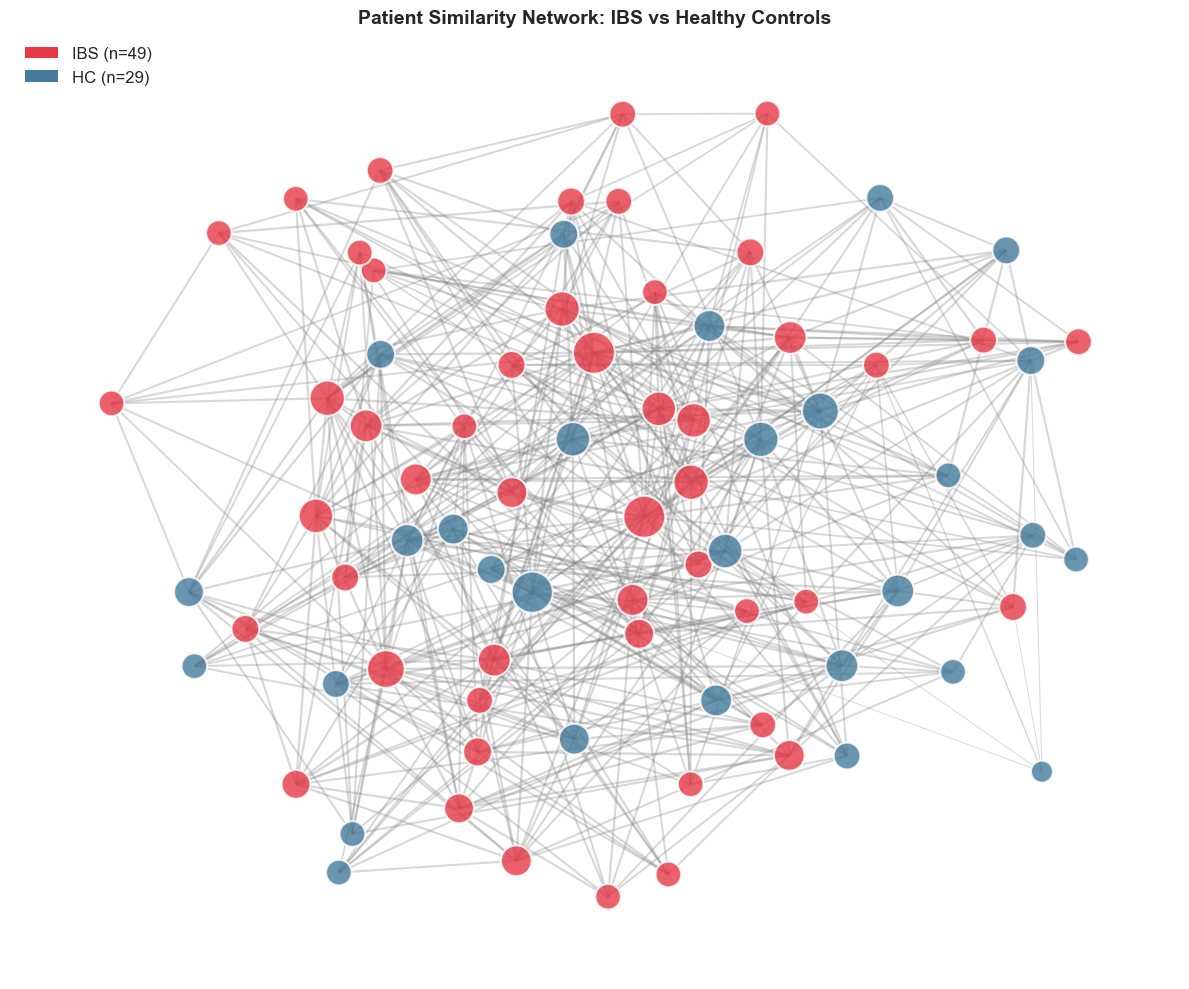


Figure: Patient similarity network based on brain morphometry and cognition

Caption: Patient similarity network constructed from 78 participants (49 IBS, 
29 HC) based on 42 features (brain morphometry and cognitive measures). Red 
nodes represent IBS patients, blue nodes represent healthy controls. Node size 
reflects degree (number of connections). Edges indicate high similarity between 
patients based on Gaussian kernel-transformed Euclidean distances in 
standardized feature space.



In [6]:
# ============================================================
# Figure Network Visualization
# ============================================================
from matplotlib.patches import Patch

# Get node colors based on group
node_colors = [GROUP_COLORS[G.nodes[n]['group']] for n in G.nodes()]

# Get edge weights for width/transparency
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_widths = [w * 2 for w in edge_weights]

# Compute node sizes based on degree
degrees = dict(G.degree())
node_sizes = [100 + degrees[n] * 30 for n in G.nodes()]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, alpha=0.3, edge_color='gray')

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes,
                       alpha=0.8, edgecolors='white', linewidths=1.5)

# Add legend
legend_elements = [Patch(facecolor=GROUP_COLORS['IBS'], label=f'IBS (n={sum(groups=="IBS")})'),
                   Patch(facecolor=GROUP_COLORS['HC'], label=f'HC (n={sum(groups=="HC")})')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

ax.set_title('Patient Similarity Network: IBS vs Healthy Controls', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Figure: Patient similarity network based on brain morphometry and cognition")
print("="*70)
print("""
Caption: Patient similarity network constructed from 78 participants (49 IBS, 
29 HC) based on 42 features (brain morphometry and cognitive measures). Red 
nodes represent IBS patients, blue nodes represent healthy controls. Node size 
reflects degree (number of connections). Edges indicate high similarity between 
patients based on Gaussian kernel-transformed Euclidean distances in 
standardized feature space.
""")


### 3.2 Community Detection

Community detection identifies groups of nodes more densely connected to each other than to the rest of the network. We use the Louvain algorithm, which optimizes modularity. We evaluate how well detected communities correspond to actual groups (IBS/HC) using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).


In [7]:
# ============================================================
# Community Detection with Louvain
# ============================================================

# Run Louvain community detection
communities = community_louvain.best_partition(G, weight='weight', random_state=42)

# Convert to list for easy indexing
community_labels = [communities[i] for i in range(len(communities))]
n_communities = len(set(community_labels))

# Compute evaluation metrics
ari = adjusted_rand_score(group_numeric, community_labels)
nmi = normalized_mutual_info_score(group_numeric, community_labels)

print(f"Community detection complete!")
print(f"  - Communities detected: {n_communities}")
print(f"  - Adjusted Rand Index (ARI): {ari:.3f}")
print(f"  - Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"\nARI interpretation:")
print(f"  - 1.0 = Perfect match with actual groups")
print(f"  - 0.0 = Random grouping")
print(f"  - < 0 = Worse than random")

# Analyze community composition
print(f"\nCommunity composition:")
print("-" * 50)
for comm_id in range(n_communities):
    nodes_in_comm = [n for n, c in communities.items() if c == comm_id]
    n_total = len(nodes_in_comm)
    n_ibs = sum(1 for n in nodes_in_comm if groups[n] == 'IBS')
    n_hc = sum(1 for n in nodes_in_comm if groups[n] == 'HC')
    pct_ibs = 100 * n_ibs / n_total if n_total > 0 else 0
    print(f"  Community {comm_id+1}: {n_total} patients ({n_ibs} IBS, {n_hc} HC) - {pct_ibs:.1f}% IBS")

# ============================================================
# Network Modularity Analysis
# ============================================================
print("\n" + "=" * 70)
print("NETWORK MODULARITY ANALYSIS")
print("=" * 70)

# Compute modularity of detected partition
modularity = community_louvain.modularity(communities, G, weight='weight')
print(f"\nObserved modularity (Q): {modularity:.4f}")

# Compare to random null model (configuration model)
n_random = 100
random_modularities = []
for _ in range(n_random):
    # Shuffle community assignments
    random_partition = dict(zip(communities.keys(), 
                                np.random.permutation(list(communities.values()))))
    random_mod = community_louvain.modularity(random_partition, G, weight='weight')
    random_modularities.append(random_mod)

null_mean = np.mean(random_modularities)
null_std = np.std(random_modularities)
z_score = (modularity - null_mean) / null_std if null_std > 0 else 0
p_mod = np.mean(np.array(random_modularities) >= modularity)

print(f"Null model modularity: {null_mean:.4f} +/- {null_std:.4f}")
print(f"Z-score: {z_score:.2f}")
print(f"p-value (vs null): {p_mod:.4f}")

if p_mod < 0.05:
    print("--> Modularity significantly exceeds random expectation")
else:
    print("--> Modularity does not significantly exceed random expectation")

# Assortative mixing by diagnosis
# Compute fraction of edges within vs between diagnostic groups
n_within_ibs = 0
n_within_hc = 0
n_between = 0
for u, v in G.edges():
    if groups[u] == groups[v]:
        if groups[u] == 'IBS':
            n_within_ibs += 1
        else:
            n_within_hc += 1
    else:
        n_between += 1

total_edges = G.number_of_edges()
print(f"\nEdge distribution by diagnosis:")
print(f"  Within IBS: {n_within_ibs} ({100*n_within_ibs/total_edges:.1f}%)")
print(f"  Within HC:  {n_within_hc} ({100*n_within_hc/total_edges:.1f}%)")
print(f"  Between:    {n_between} ({100*n_between/total_edges:.1f}%)")

# Assortativity coefficient by group
assortativity = nx.attribute_assortativity_coefficient(G, 'group')
print(f"\nAssortativity coefficient (by diagnosis): {assortativity:.4f}")
print("  (1 = perfectly assortative, 0 = random, -1 = disassortative)")


Community detection complete!
  - Communities detected: 4
  - Adjusted Rand Index (ARI): 0.011
  - Normalized Mutual Information (NMI): 0.037

ARI interpretation:
  - 1.0 = Perfect match with actual groups
  - 0.0 = Random grouping
  - < 0 = Worse than random

Community composition:
--------------------------------------------------
  Community 1: 23 patients (15 IBS, 8 HC) - 65.2% IBS
  Community 2: 12 patients (9 IBS, 3 HC) - 75.0% IBS
  Community 3: 23 patients (10 IBS, 13 HC) - 43.5% IBS
  Community 4: 20 patients (15 IBS, 5 HC) - 75.0% IBS

NETWORK MODULARITY ANALYSIS

Observed modularity (Q): 0.4114
Null model modularity: -0.0099 +/- 0.0172
Z-score: 24.48
p-value (vs null): 0.0000
--> Modularity significantly exceeds random expectation

Edge distribution by diagnosis:
  Within IBS: 187 (39.9%)
  Within HC:  72 (15.4%)
  Between:    210 (44.8%)

Assortativity coefficient (by diagnosis): 0.0472
  (1 = perfectly assortative, 0 = random, -1 = disassortative)


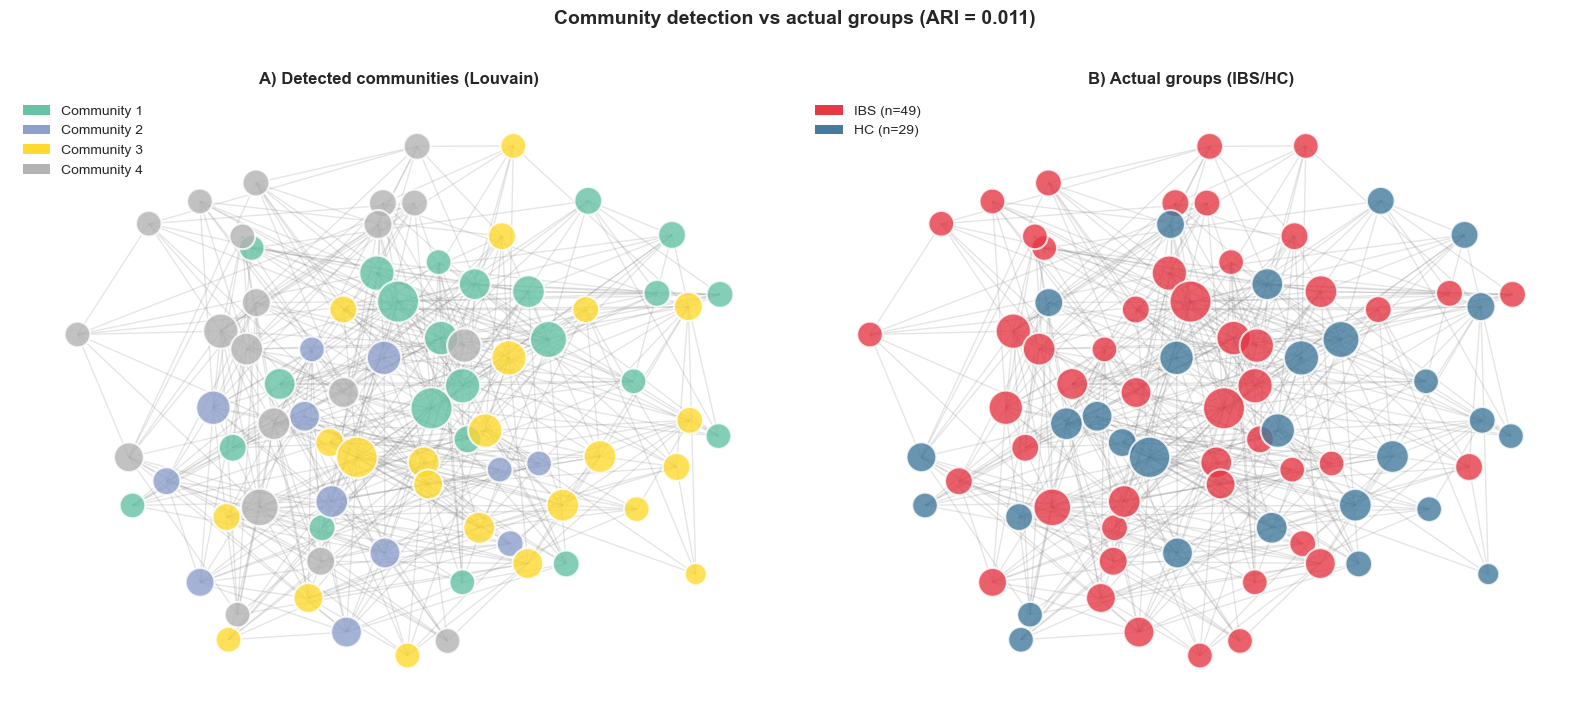


Figure Caption: (A) Network with nodes colored by detected communities from Louvain algorithm.
(B) Same network with nodes colored by actual diagnosis (IBS=red, HC=blue). ARI = 0.011.


In [8]:
# ============================================================
# Figure: Community Detection Visualization
# ============================================================

# Create colormap for communities
cmap = plt.cm.get_cmap('Set2', n_communities)
community_colors = [cmap(communities[n]) for n in G.nodes()]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Colored by community
ax1 = axes[0]
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=community_colors, node_size=node_sizes,
                       alpha=0.8, edgecolors='white', linewidths=1.5)
ax1.set_title('A) Detected communities (Louvain)', fontsize=12, fontweight='bold')
legend_comm = [Patch(facecolor=cmap(i), label=f'Community {i+1}') for i in range(n_communities)]
ax1.legend(handles=legend_comm, loc='upper left', fontsize=10)
ax1.axis('off')

# Right: Colored by actual group
ax2 = axes[1]
nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=ax2, node_color=node_colors, node_size=node_sizes,
                       alpha=0.8, edgecolors='white', linewidths=1.5)
ax2.set_title('B) Actual groups (IBS/HC)', fontsize=12, fontweight='bold')
ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
ax2.axis('off')

plt.suptitle(f'Community detection vs actual groups (ARI = {ari:.3f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nFigure Caption: (A) Network with nodes colored by detected communities from Louvain algorithm.")
print(f"(B) Same network with nodes colored by actual diagnosis (IBS=red, HC=blue). ARI = {ari:.3f}.")


### 3.3 Centrality Analyses

Centrality measures identify the most important nodes in the network.


In [9]:
# ============================================================
# Compute Centrality Measures
# ============================================================

# Degree centrality
degree_cent = nx.degree_centrality(G)

# Betweenness centrality
betweenness_cent = nx.betweenness_centrality(G, weight='weight')

# Eigenvector centrality
try:
    eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
except:
    eigenvector_cent = nx.eigenvector_centrality_numpy(G, weight='weight')

# Store in DataFrame
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Subject': [subjects[n] for n in G.nodes()],
    'Group': [groups[n] for n in G.nodes()],
    'Degree': [degree_cent[n] for n in G.nodes()],
    'Betweenness': [betweenness_cent[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_cent[n] for n in G.nodes()]
})

# Add IBS_SSS for later correlation analysis
centrality_df['IBS_SSS'] = ibs_sss

print("Centrality measures computed!")
print(f"\nSummary by group:")
print("-" * 50)
for group in ['IBS', 'HC']:
    group_data = centrality_df[centrality_df['Group'] == group]
    print(f"\n{group}:")
    print(f"  Degree:      {group_data['Degree'].mean():.4f} +/- {group_data['Degree'].std():.4f}")
    print(f"  Betweenness: {group_data['Betweenness'].mean():.4f} +/- {group_data['Betweenness'].std():.4f}")
    print(f"  Eigenvector: {group_data['Eigenvector'].mean():.4f} +/- {group_data['Eigenvector'].std():.4f}")


Centrality measures computed!

Summary by group:
--------------------------------------------------

IBS:
  Degree:      0.1548 +/- 0.0611
  Betweenness: 0.0152 +/- 0.0177
  Eigenvector: 0.1041 +/- 0.0553

HC:
  Degree:      0.1585 +/- 0.0581
  Betweenness: 0.0184 +/- 0.0152
  Eigenvector: 0.0955 +/- 0.0451


---

## 4. Enhanced Analyses

### 4.1 Multiple Similarity Measures Comparison

To assess the robustness of our findings, we construct PSN using three different similarity measures and compare community detection results.


Comparing similarity measures...

EUCLIDEAN:
  Edges: 469, Communities: 4, ARI: 0.011, NMI: 0.037

COSINE:
  Edges: 418, Communities: 4, ARI: -0.017, NMI: 0.007

CORRELATION:
  Edges: 391, Communities: 4, ARI: 0.006, NMI: 0.036


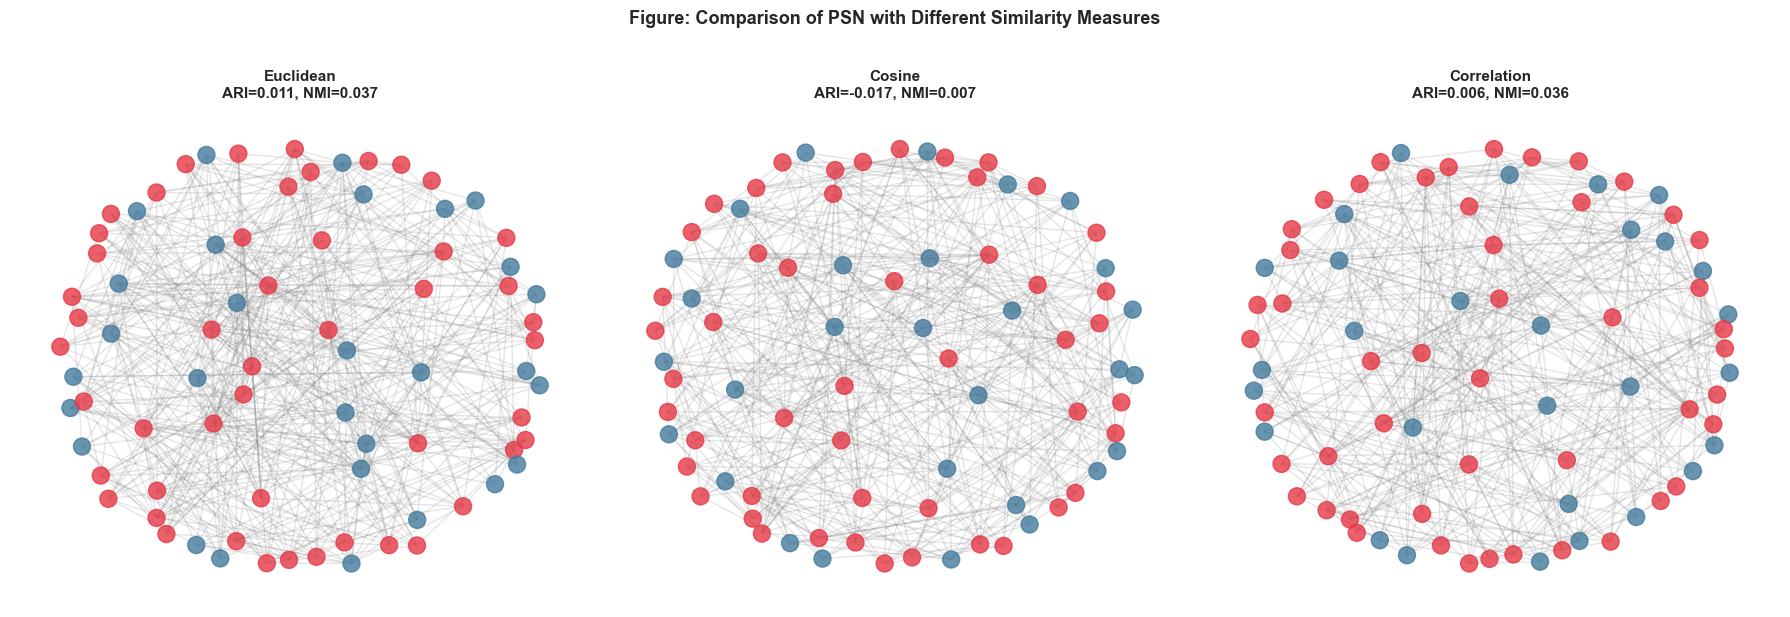


Table 1: Comparison of Similarity Measures
     Metric  Nodes  Edges  Communities       ARI      NMI
  Euclidean     78    469            4  0.011126 0.036503
     Cosine     78    418            4 -0.017495 0.006820
Correlation     78    391            4  0.005539 0.036467


In [10]:
# ============================================================
# 4.1 Multiple Similarity Measures Comparison
# ============================================================

similarity_metrics = ['euclidean', 'cosine', 'correlation']
results_similarity = []

print("Comparing similarity measures...")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(similarity_metrics):
    # Build network
    G_temp, sim_temp = create_psn(X_scaled, subjects, groups, threshold=0.3, k_nearest=8, metric=metric)
    
    # Community detection
    comm_temp = community_louvain.best_partition(G_temp, weight='weight', random_state=42)
    labels_temp = [comm_temp[i] for i in range(len(comm_temp))]
    
    # Compute metrics
    ari_temp = adjusted_rand_score(group_numeric, labels_temp)
    nmi_temp = normalized_mutual_info_score(group_numeric, labels_temp)
    
    results_similarity.append({
        'Metric': metric.capitalize(),
        'Nodes': G_temp.number_of_nodes(),
        'Edges': G_temp.number_of_edges(),
        'Communities': len(set(labels_temp)),
        'ARI': ari_temp,
        'NMI': nmi_temp
    })
    
    print(f"\n{metric.upper()}:")
    print(f"  Edges: {G_temp.number_of_edges()}, Communities: {len(set(labels_temp))}, ARI: {ari_temp:.3f}, NMI: {nmi_temp:.3f}")
    
    # Visualization
    ax = axes[idx]
    pos_temp = nx.spring_layout(G_temp, k=2, seed=42)
    node_colors_temp = [GROUP_COLORS[G_temp.nodes[n]['group']] for n in G_temp.nodes()]
    nx.draw_networkx_edges(G_temp, pos_temp, ax=ax, alpha=0.2, edge_color='gray')
    nx.draw_networkx_nodes(G_temp, pos_temp, ax=ax, node_color=node_colors_temp, node_size=150, alpha=0.8)
    ax.set_title(f'{metric.capitalize()}\nARI={ari_temp:.3f}, NMI={nmi_temp:.3f}', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Figure: Comparison of PSN with Different Similarity Measures', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
similarity_df = pd.DataFrame(results_similarity)
print("\n" + "=" * 70)
print("Table 1: Comparison of Similarity Measures")
print("=" * 70)
print(similarity_df.to_string(index=False))


### 4.2 Sensitivity Analysis

We assess how network construction parameters (k-nearest neighbors and similarity threshold) affect community detection performance.


Running sensitivity analysis...


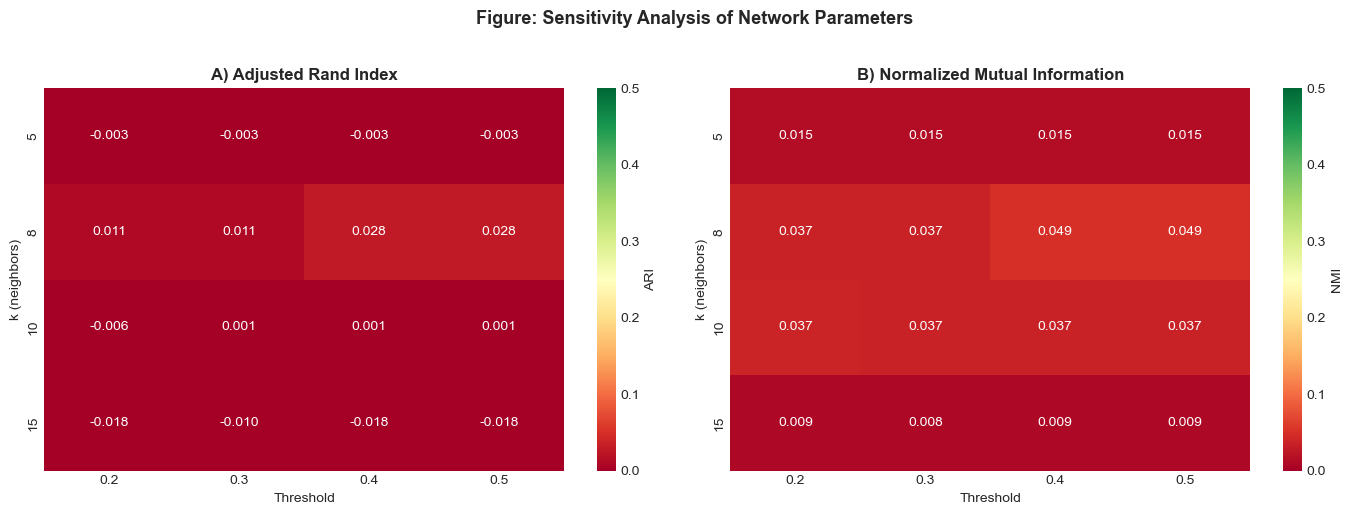


Best ARI: 0.028 at k=8, threshold=0.4


In [11]:
# ============================================================
# 4.2 Sensitivity Analysis: k-NN and Threshold
# ============================================================

k_values = [5, 8, 10, 15]
threshold_values = [0.2, 0.3, 0.4, 0.5]

sensitivity_results = []

print("Running sensitivity analysis...")
print("=" * 70)

for k in k_values:
    for thresh in threshold_values:
        G_temp, _ = create_psn(X_scaled, subjects, groups, threshold=thresh, k_nearest=k)
        
        if G_temp.number_of_edges() > 0:
            comm_temp = community_louvain.best_partition(G_temp, weight='weight', random_state=42)
            labels_temp = [comm_temp[i] for i in range(len(comm_temp))]
            ari_temp = adjusted_rand_score(group_numeric, labels_temp)
            nmi_temp = normalized_mutual_info_score(group_numeric, labels_temp)
        else:
            ari_temp = nmi_temp = 0
        
        sensitivity_results.append({
            'k': k,
            'threshold': thresh,
            'edges': G_temp.number_of_edges(),
            'ARI': ari_temp,
            'NMI': nmi_temp
        })

sens_df = pd.DataFrame(sensitivity_results)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pivot for ARI
ari_pivot = sens_df.pivot(index='k', columns='threshold', values='ARI')
sns.heatmap(ari_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], vmin=0, vmax=0.5,
            cbar_kws={'label': 'ARI'})
axes[0].set_title('A) Adjusted Rand Index', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('k (neighbors)')

# Pivot for NMI
nmi_pivot = sens_df.pivot(index='k', columns='threshold', values='NMI')
sns.heatmap(nmi_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], vmin=0, vmax=0.5,
            cbar_kws={'label': 'NMI'})
axes[1].set_title('B) Normalized Mutual Information', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('k (neighbors)')

plt.suptitle('Figure: Sensitivity Analysis of Network Parameters', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Best parameters
best_ari = sens_df.loc[sens_df['ARI'].idxmax()]
print(f"\nBest ARI: {best_ari['ARI']:.3f} at k={int(best_ari['k'])}, threshold={best_ari['threshold']}")


### 4.3 Statistical Validation

We perform bootstrap resampling for confidence intervals and permutation testing to assess statistical significance of ARI/NMI values.


In [12]:
# ============================================================
# 4.3a Bootstrap Confidence Intervals
# ============================================================

n_bootstrap = 1000
bootstrap_ari = []
bootstrap_nmi = []

print(f"Bootstrap resampling ({n_bootstrap} iterations)...")

for i in range(n_bootstrap):
    # Sample with replacement
    idx = np.random.choice(len(X_scaled), size=len(X_scaled), replace=True)
    X_boot = X_scaled[idx]
    groups_boot = groups[idx]
    subjects_boot = subjects[idx]
    groups_boot_num = group_numeric[idx]
    
    # Build network and detect communities
    G_boot, _ = create_psn(X_boot, subjects_boot, groups_boot, threshold=0.3, k_nearest=8)
    
    if G_boot.number_of_edges() > 0:
        comm_boot = community_louvain.best_partition(G_boot, weight='weight', random_state=i)
        labels_boot = [comm_boot[j] for j in range(len(comm_boot))]
        bootstrap_ari.append(adjusted_rand_score(groups_boot_num, labels_boot))
        bootstrap_nmi.append(normalized_mutual_info_score(groups_boot_num, labels_boot))
    else:
        bootstrap_ari.append(0)
        bootstrap_nmi.append(0)

# Compute confidence intervals
ari_ci = np.percentile(bootstrap_ari, [2.5, 97.5])
nmi_ci = np.percentile(bootstrap_nmi, [2.5, 97.5])

print(f"\n95% Confidence Intervals:")
print(f"  ARI: {np.mean(bootstrap_ari):.3f} [{ari_ci[0]:.3f}, {ari_ci[1]:.3f}]")
print(f"  NMI: {np.mean(bootstrap_nmi):.3f} [{nmi_ci[0]:.3f}, {nmi_ci[1]:.3f}]")


Bootstrap resampling (1000 iterations)...

95% Confidence Intervals:
  ARI: 0.025 [-0.016, 0.102]
  NMI: 0.067 [0.007, 0.168]


In [13]:
# ============================================================
# 4.3b Permutation Testing
# ============================================================

n_permutations = 1000
perm_ari = []
perm_nmi = []

print(f"Permutation testing ({n_permutations} iterations)...")

for i in range(n_permutations):
    # Shuffle group labels
    groups_perm = np.random.permutation(group_numeric)
    
    # Use existing network, evaluate with permuted labels
    perm_ari.append(adjusted_rand_score(groups_perm, community_labels))
    perm_nmi.append(normalized_mutual_info_score(groups_perm, community_labels))

# Compute p-values
p_value_ari = np.mean(np.array(perm_ari) >= ari)
p_value_nmi = np.mean(np.array(perm_nmi) >= nmi)

print(f"\nPermutation test results:")
print(f"  Observed ARI: {ari:.3f}, p-value: {p_value_ari:.4f}")
print(f"  Observed NMI: {nmi:.3f}, p-value: {p_value_nmi:.4f}")
print(f"\nInterpretation: p < 0.05 indicates communities match actual groups better than chance")


Permutation testing (1000 iterations)...

Permutation test results:
  Observed ARI: 0.011, p-value: 0.2120
  Observed NMI: 0.037, p-value: 0.1460

Interpretation: p < 0.05 indicates communities match actual groups better than chance


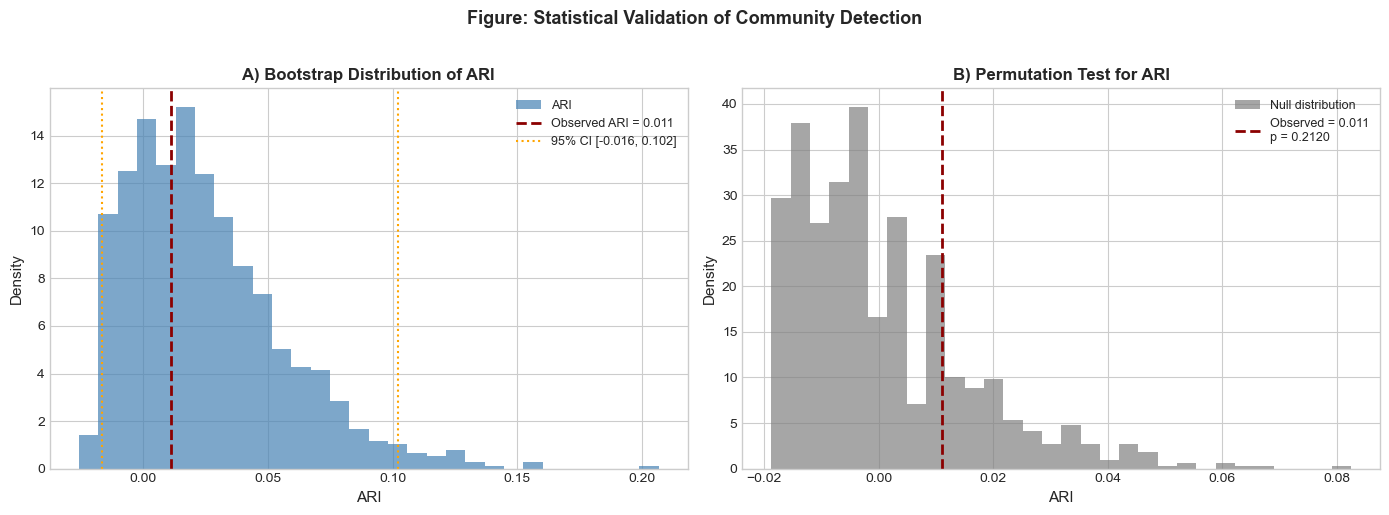


Caption: (A) Bootstrap distribution showing 95% CI for ARI. (B) Null distribution from permutation test.


In [14]:
# ============================================================
# Figure: Statistical Validation
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bootstrap distributions
ax1 = axes[0]
ax1.hist(bootstrap_ari, bins=30, alpha=0.7, color='steelblue', label='ARI', density=True)
ax1.axvline(ari, color='darkred', linestyle='--', linewidth=2, label=f'Observed ARI = {ari:.3f}')
ax1.axvline(ari_ci[0], color='orange', linestyle=':', label=f'95% CI [{ari_ci[0]:.3f}, {ari_ci[1]:.3f}]')
ax1.axvline(ari_ci[1], color='orange', linestyle=':')
ax1.set_xlabel('ARI', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('A) Bootstrap Distribution of ARI', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)

# Permutation distribution
ax2 = axes[1]
ax2.hist(perm_ari, bins=30, alpha=0.7, color='gray', label='Null distribution', density=True)
ax2.axvline(ari, color='darkred', linestyle='--', linewidth=2, label=f'Observed = {ari:.3f}\np = {p_value_ari:.4f}')
ax2.set_xlabel('ARI', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('B) Permutation Test for ARI', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)

plt.suptitle('Figure: Statistical Validation of Community Detection', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nCaption: (A) Bootstrap distribution showing 95% CI for ARI. (B) Null distribution from permutation test.")


### 4.4 Hierarchical Clustering Comparison

We compare Louvain community detection with agglomerative hierarchical clustering using Ward's method.


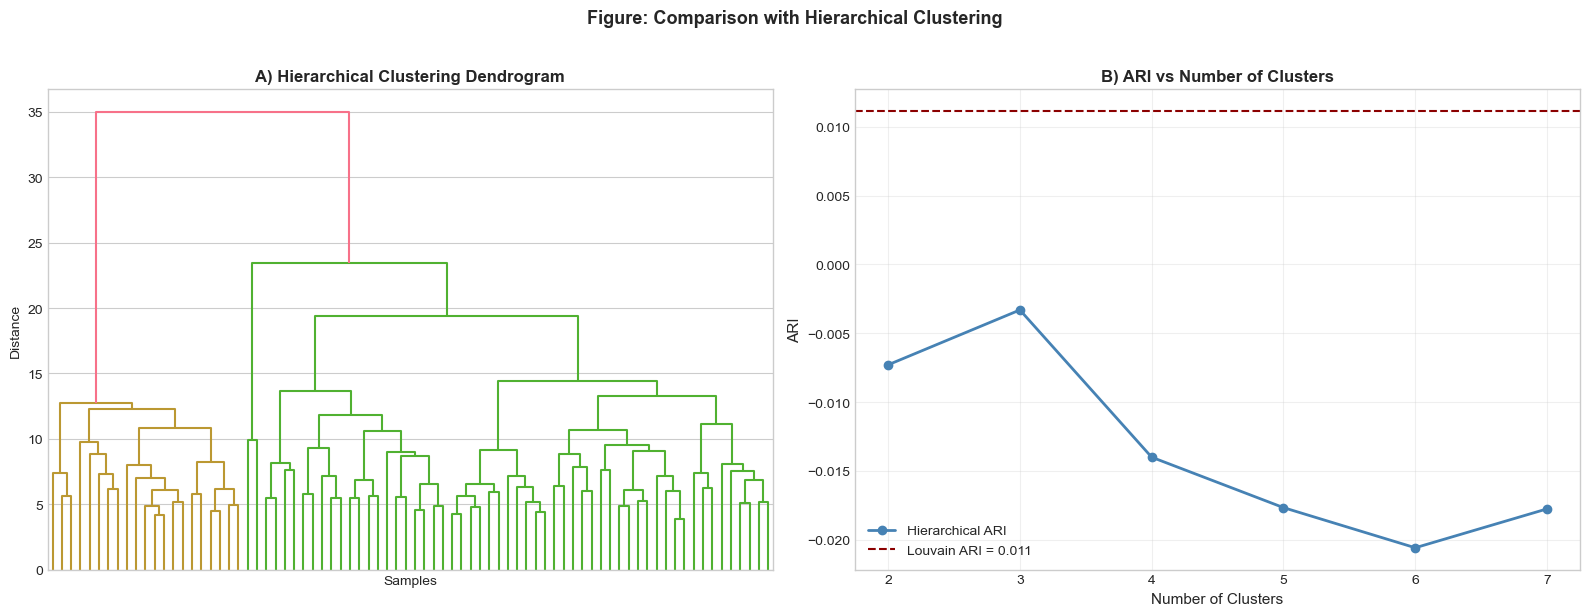


Hierarchical clustering: Best k=3 with ARI=-0.003
Louvain: 4 communities with ARI=0.011


In [15]:
# ============================================================
# 4.4 Hierarchical Clustering Comparison
# ============================================================

# Perform hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')

# Compare different numbers of clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dendrogram
ax1 = axes[0]
dendrogram(linkage_matrix, ax=ax1, no_labels=True, color_threshold=0.7*max(linkage_matrix[:,2]))
ax1.set_title('A) Hierarchical Clustering Dendrogram', fontsize=12, fontweight='bold')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Distance')

# ARI comparison for different k
ax2 = axes[1]
k_range = range(2, 8)
hc_ari = []
hc_nmi = []

for k in k_range:
    hc_labels = fcluster(linkage_matrix, k, criterion='maxclust')
    hc_ari.append(adjusted_rand_score(group_numeric, hc_labels))
    hc_nmi.append(normalized_mutual_info_score(group_numeric, hc_labels))

ax2.plot(k_range, hc_ari, 'o-', color='steelblue', label='Hierarchical ARI', linewidth=2)
ax2.axhline(ari, color='darkred', linestyle='--', label=f'Louvain ARI = {ari:.3f}')
ax2.set_xlabel('Number of Clusters', fontsize=11)
ax2.set_ylabel('ARI', fontsize=11)
ax2.set_title('B) ARI vs Number of Clusters', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Figure: Comparison with Hierarchical Clustering', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Best k for hierarchical
best_k = k_range[np.argmax(hc_ari)]
print(f"\nHierarchical clustering: Best k={best_k} with ARI={max(hc_ari):.3f}")
print(f"Louvain: {n_communities} communities with ARI={ari:.3f}")


### 4.5 Network Robustness Analysis

We assess network stability by progressively removing edges and evaluating impact on community detection.


Assessing network robustness...


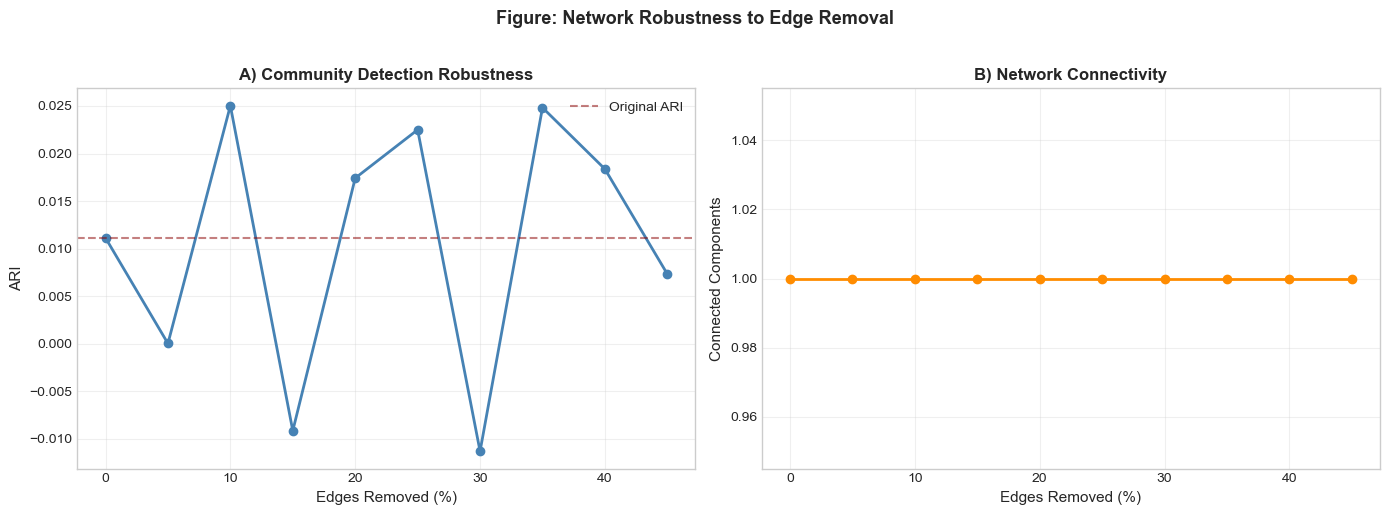

In [16]:
# ============================================================
# 4.5 Network Robustness Analysis
# ============================================================

removal_fractions = np.arange(0, 0.5, 0.05)
robustness_ari = []
robustness_components = []

print("Assessing network robustness...")

for frac in removal_fractions:
    G_copy = G.copy()
    n_remove = int(frac * G_copy.number_of_edges())
    
    if n_remove > 0:
        edges = list(G_copy.edges())
        edges_to_remove = np.random.choice(len(edges), n_remove, replace=False)
        for idx in edges_to_remove:
            G_copy.remove_edge(*edges[idx])
    
    if G_copy.number_of_edges() > 0:
        comm = community_louvain.best_partition(G_copy, weight='weight', random_state=42)
        labels = [comm[i] for i in range(len(comm))]
        robustness_ari.append(adjusted_rand_score(group_numeric, labels))
    else:
        robustness_ari.append(0)
    
    robustness_components.append(nx.number_connected_components(G_copy))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(removal_fractions * 100, robustness_ari, 'o-', color='steelblue', linewidth=2)
ax1.axhline(ari, color='darkred', linestyle='--', alpha=0.5, label='Original ARI')
ax1.set_xlabel('Edges Removed (%)', fontsize=11)
ax1.set_ylabel('ARI', fontsize=11)
ax1.set_title('A) Community Detection Robustness', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(removal_fractions * 100, robustness_components, 'o-', color='darkorange', linewidth=2)
ax2.set_xlabel('Edges Removed (%)', fontsize=11)
ax2.set_ylabel('Connected Components', fontsize=11)
ax2.set_title('B) Network Connectivity', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Figure: Network Robustness to Edge Removal', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 4.6 Subgroup Clinical Profiling

We characterize detected communities by examining clinical features within each subgroup.


In [17]:
# ============================================================
# 4.6 Subgroup Clinical Profiling with Statistical Testing
# ============================================================
from scipy.stats import kruskal, chi2_contingency, mannwhitneyu
from itertools import combinations

# Create profiling dataframe
profile_df = df.copy()
profile_df['Community'] = [communities[i] + 1 for i in range(len(communities))]

# Key variables for profiling
profile_vars = ['IBS_SSS'] + COGNITIVE_COLS + ['Age']

print("Community Clinical Profiles (Table 3):")
print("=" * 80)

profile_summary = []

for comm_id in range(1, n_communities + 1):
    comm_data = profile_df[profile_df['Community'] == comm_id]
    n_ibs = sum(comm_data['Group'] == 'IBS')
    n_hc = sum(comm_data['Group'] == 'HC')
    
    row = {
        'Community': comm_id,
        'N': len(comm_data),
        'IBS': n_ibs,
        'HC': n_hc,
        '% IBS': 100 * n_ibs / len(comm_data)
    }
    
    for var in profile_vars:
        row[f'{var}_mean'] = comm_data[var].mean()
        row[f'{var}_std'] = comm_data[var].std()
    
    profile_summary.append(row)

profile_table = pd.DataFrame(profile_summary)

# Display key features
print(f"\n{'Community':<12} {'N':<5} {'IBS':<5} {'HC':<5} {'%IBS':<8} {'IBS-SSS':<15} {'RBANS':<15}")
print("-" * 80)
for _, row in profile_table.iterrows():
    ibs_sss_str = f"{row['IBS_SSS_mean']:.1f} ({row['IBS_SSS_std']:.1f})"
    rbans_str = f"{row['Fullscale_RBANS_mean']:.1f} ({row['Fullscale_RBANS_std']:.1f})"
    print(f"{int(row['Community']):<12} {int(row['N']):<5} {int(row['IBS']):<5} {int(row['HC']):<5} {row['% IBS']:.1f}%{'   ':<5} {ibs_sss_str:<15} {rbans_str:<15}")

# ============================================================
# Statistical Testing for Community Differences
# ============================================================
print("\n" + "=" * 80)
print("STATISTICAL TESTING FOR COMMUNITY DIFFERENCES")
print("=" * 80)

# 1. Chi-square test for group composition
print("\n1. Chi-square test for IBS/HC distribution across communities:")
print("-" * 60)
contingency_table = pd.crosstab(profile_df['Community'], profile_df['Group'])
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"   Chi-square = {chi2:.3f}, df = {dof}, p = {p_chi2:.4f}")
if p_chi2 < 0.05:
    print("   --> Significant: Community composition differs by diagnosis")
else:
    print("   --> Not significant: Communities have similar IBS/HC proportions")

# 2. Kruskal-Wallis tests for clinical variables
print("\n2. Kruskal-Wallis tests for clinical variables across communities:")
print("-" * 60)

kruskal_results = []
test_vars = ['IBS_SSS', 'Fullscale_RBANS', 'Age']

for var in test_vars:
    groups_data = [profile_df[profile_df['Community'] == c][var].dropna().values 
                   for c in range(1, n_communities + 1)]
    # Only test if all groups have data
    if all(len(g) > 0 for g in groups_data):
        H, p = kruskal(*groups_data)
        # Effect size: eta-squared = (H - k + 1) / (n - k)
        n_total = sum(len(g) for g in groups_data)
        eta_sq = (H - n_communities + 1) / (n_total - n_communities) if n_total > n_communities else 0
        kruskal_results.append({'Variable': var, 'H': H, 'p': p, 'eta_sq': eta_sq})
        sig = "*" if p < 0.05 else ""
        print(f"   {var:<20}: H = {H:.2f}, p = {p:.4f}, eta² = {eta_sq:.3f} {sig}")

# 3. Post-hoc pairwise comparisons (if significant)
print("\n3. Post-hoc pairwise comparisons (Mann-Whitney U with Bonferroni correction):")
print("-" * 60)

n_comparisons = n_communities * (n_communities - 1) // 2
alpha_bonf = 0.05 / n_comparisons
print(f"   Bonferroni-corrected alpha: {alpha_bonf:.4f} (n_comparisons = {n_comparisons})")

for var in test_vars:
    var_results = [r for r in kruskal_results if r['Variable'] == var]
    if var_results and var_results[0]['p'] < 0.05:
        print(f"\n   {var} (significant in omnibus test):")
        for c1, c2 in combinations(range(1, n_communities + 1), 2):
            data1 = profile_df[profile_df['Community'] == c1][var].dropna()
            data2 = profile_df[profile_df['Community'] == c2][var].dropna()
            if len(data1) > 0 and len(data2) > 0:
                U, p = mannwhitneyu(data1, data2, alternative='two-sided')
                sig = "*" if p < alpha_bonf else ""
                print(f"      Community {c1} vs {c2}: U = {U:.1f}, p = {p:.4f} {sig}")

# 4. Demographics by community
print("\n4. Demographics by community:")
print("-" * 60)
print(f"   {'Community':<12} {'Age (mean±SD)':<18} {'Female %':<12}")
for comm_id in range(1, n_communities + 1):
    comm_data = profile_df[profile_df['Community'] == comm_id]
    age_str = f"{comm_data['Age'].mean():.1f} ± {comm_data['Age'].std():.1f}"
    # Check if Gender column exists
    if 'Gender' in comm_data.columns:
        female_pct = 100 * (comm_data['Gender'] == 'F').sum() / len(comm_data)
        print(f"   {comm_id:<12} {age_str:<18} {female_pct:.1f}%")
    else:
        print(f"   {comm_id:<12} {age_str:<18} N/A")

# Store results for manuscript
community_stats = {
    'chi2': chi2, 'p_chi2': p_chi2,
    'kruskal_results': kruskal_results,
    'n_comparisons': n_comparisons
}


Community Clinical Profiles (Table 3):

Community    N     IBS   HC    %IBS     IBS-SSS         RBANS          
--------------------------------------------------------------------------------
1            23    15    8     65.2%      179.3 (128.4)   101.8 (13.4)   
2            12    9     3     75.0%      240.6 (140.6)   92.0 (15.8)    
3            23    10    13    43.5%      134.1 (135.1)   99.5 (9.8)     
4            20    15    5     75.0%      208.8 (123.8)   84.3 (10.9)    

STATISTICAL TESTING FOR COMMUNITY DIFFERENCES

1. Chi-square test for IBS/HC distribution across communities:
------------------------------------------------------------
   Chi-square = 5.773, df = 3, p = 0.1232
   --> Not significant: Communities have similar IBS/HC proportions

2. Kruskal-Wallis tests for clinical variables across communities:
------------------------------------------------------------
   IBS_SSS             : H = 6.10, p = 0.1068, eta² = 0.042 
   Fullscale_RBANS     : H = 21.40, p =

### 4.6.1 Community Feature Profiles

We compute mean z-scores for each feature within each community to identify the distinguishing brain morphometry and cognitive characteristics of each patient subgroup.


Community Feature Profiles (Mean Z-scores):

Top 5 ELEVATED features per community (highest mean z-scores):
--------------------------------------------------------------------------------

Community 1:
  [M] eTIV                               : +0.612
  [C] Total Scale                        : +0.481
  [C] Visuospatial/Constructional        : +0.411
  [C] Attention                          : +0.388
  [C] Language                           : +0.336

Community 2:
  [M] lhCortexVol                        : +0.720
  [M] CortexVol                          : +0.702
  [M] rhCortexVol                        : +0.679
  [M] TotalGrayVol                       : +0.636
  [M] Right Cerebellum Cortex            : +0.573

Community 3:
  [M] SubCortGrayVol                     : +1.078
  [M] Left Pallidum                      : +0.982
  [M] Right Pallidum                     : +0.934
  [M] BrainSegVolNotVent                 : +0.921
  [M] BrainSegVol                        : +0.886

Community 4:
  [M]

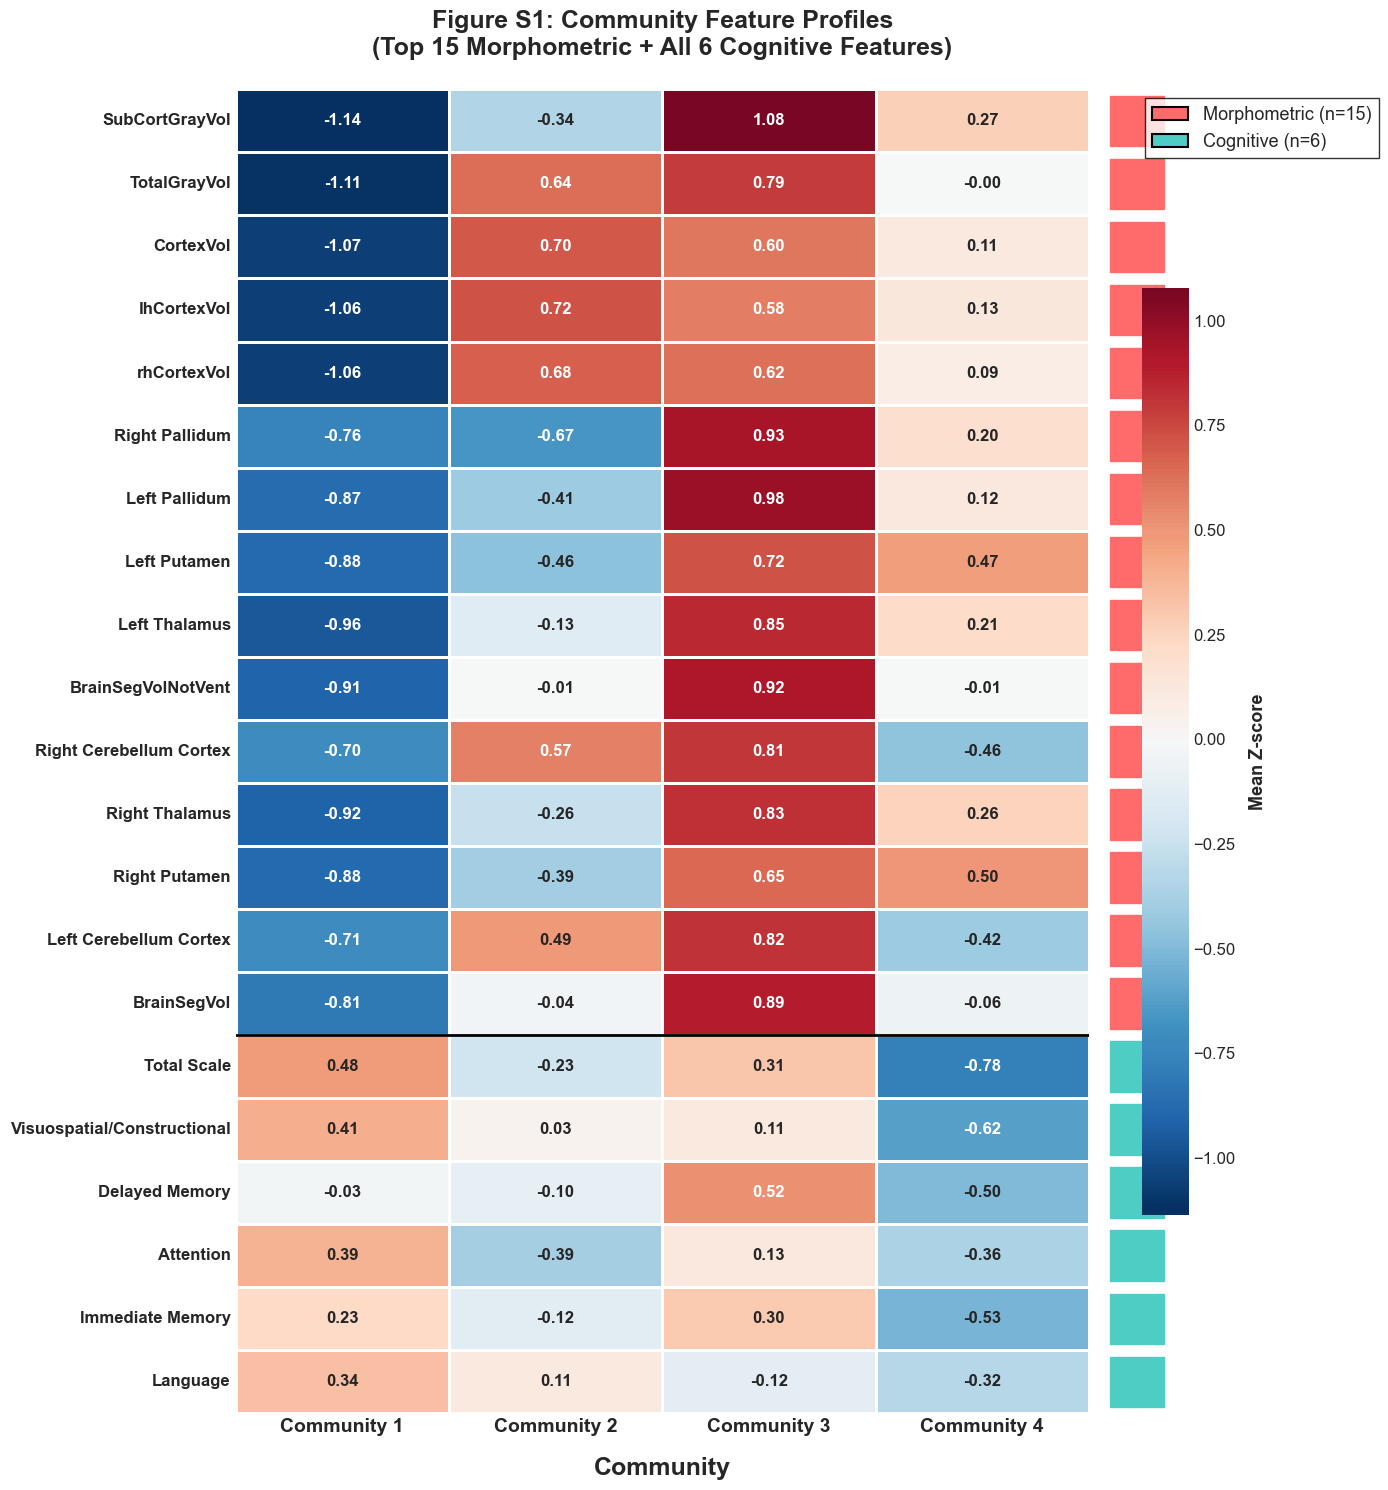


Figure saved to: ../manus/figs/fig_S1_community_features.png

 and to: ../manus/figs/fig_S1_community_features.pdf
Features shown: 15 morphometric + 6 cognitive = 21 total


In [18]:
# ============================================================
# 4.6.1 Community Feature Profiles (Figure S1)
# ============================================================

# Create DataFrame with standardized features and community assignments
feature_profile_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS)
feature_profile_df['Community'] = [communities[i] + 1 for i in range(len(communities))]

# Compute mean z-scores for each feature within each community
community_feature_means = feature_profile_df.groupby('Community')[FEATURE_COLS].mean()

print("Community Feature Profiles (Mean Z-scores):")
print("=" * 80)
print("\nTop 5 ELEVATED features per community (highest mean z-scores):")
print("-" * 80)

top_elevated = {}
top_reduced = {}

for comm_id in range(1, n_communities + 1):
    comm_means = community_feature_means.loc[comm_id].sort_values(ascending=False)
    top_elevated[comm_id] = comm_means.head(5)
    top_reduced[comm_id] = comm_means.tail(5).sort_values()
    
    print(f"\nCommunity {comm_id}:")
    for feat, val in top_elevated[comm_id].items():
        feat_type = "M" if feat in MORPHOMETRY_COLS else "C"
        print(f"  [{feat_type}] {get_display_name(feat):<35}: {val:+.3f}")

print("\n" + "=" * 80)
print("Top 5 REDUCED features per community (lowest mean z-scores):")
print("-" * 80)

for comm_id in range(1, n_communities + 1):
    print(f"\nCommunity {comm_id}:")
    for feat, val in top_reduced[comm_id].items():
        feat_type = "M" if feat in MORPHOMETRY_COLS else "C"
        print(f"  [{feat_type}] {get_display_name(feat):<35}: {val:+.3f}")

# ============================================================
# Create summary table for manuscript
# ============================================================
print("\n" + "=" * 80)
print("SUMMARY TABLE: Top 3 Distinguishing Features per Community")
print("(for manuscript Table 4)")
print("=" * 80)

# For each community, find most distinctive features (largest absolute z-scores)
print(f"\n{'Community':<12} {'Top Elevated Features':<50} {'Top Reduced Features':<50}")
print("-" * 112)

for comm_id in range(1, n_communities + 1):
    comm_means = community_feature_means.loc[comm_id]
    
    # Top 3 elevated
    top3_up = comm_means.nlargest(3)
    top3_up_str = "; ".join([f"{f[:20]}({v:+.2f})" for f, v in top3_up.items()])
    
    # Top 3 reduced  
    top3_down = comm_means.nsmallest(3)
    top3_down_str = "; ".join([f"{f[:20]}({v:+.2f})" for f, v in top3_down.items()])
    
    print(f"{comm_id:<12} {top3_up_str:<50} {top3_down_str:<50}")

# ============================================================
# Visualization: Heatmap of community feature profiles
# ============================================================
fig, ax = plt.subplots(figsize=(14, 15))

# BALANCED SELECTION: Top 15 morphometric + all 6 cognitive features
feature_variance = community_feature_means.var()

# Get top 15 morphometric features by variance
morph_variance = feature_variance[MORPHOMETRY_COLS].nlargest(15)
top_morph_features = morph_variance.index.tolist()

# All cognitive features
cog_features = COGNITIVE_COLS.copy()

# Combine: morphometric first (sorted by variance), then cognitive (sorted by variance)
cog_variance = feature_variance[COGNITIVE_COLS].sort_values(ascending=False)
selected_features = top_morph_features + cog_variance.index.tolist()

# Create display names for features (shorter, cleaner names)
display_names = [get_display_name(f) for f in selected_features]

# Create heatmap data
heatmap_data = community_feature_means[selected_features].T
heatmap_data.index = display_names  # Use display names

# Color features by type - use high contrast colors
row_colors = ['#FF6B6B' if f in MORPHOMETRY_COLS else '#4ECDC4' for f in selected_features]

# Create heatmap with larger fonts
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, cbar_kws={'label': 'Mean Z-score', 'shrink': 0.7},
            linewidths=1, linecolor='white', annot_kws={'fontsize': 12, 'fontweight': 'bold'})

# Improve font sizes throughout
ax.set_xlabel('Community', fontsize=18, fontweight='bold', labelpad=15)
ax.set_ylabel('', fontsize=18, fontweight='bold')  # Remove y-label, features are self-explanatory
ax.set_title('Figure S1: Community Feature Profiles\n(Top 15 Morphometric + All 6 Cognitive Features)', 
             fontsize=18, fontweight='bold', pad=25)
ax.set_xticklabels([f'Community {i}' for i in range(1, n_communities + 1)], 
                   fontsize=14, fontweight='bold', rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')

# Improve colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Mean Z-score', fontsize=13, fontweight='bold', labelpad=10)

# Add colored squares next to y-axis labels (outside the plot area)
for i, color in enumerate(row_colors):
    # Position squares to the right of the heatmap, after x=4
    ax.add_patch(plt.Rectangle((4.1, i + 0.1), 0.25, 0.8, color=color, clip_on=False, 
                               edgecolor='black', linewidth=1))

# Add horizontal line to separate morphometric from cognitive features
ax.axhline(y=len(top_morph_features), color='black', linewidth=2, linestyle='-')

# Legend with improved styling - position at top right
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', edgecolor='black', linewidth=1.5, label='Morphometric (n=15)'),
                   Patch(facecolor='#4ECDC4', edgecolor='black', linewidth=1.5, label='Cognitive (n=6)')]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.0), 
          fontsize=13, frameon=True, edgecolor='black', fancybox=False)

plt.tight_layout()

# ===== FIGURE S1 =======================================================

plt.savefig('../manus/figs/fig_S1_community_features.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('../manus/figs/fig_S1_community_features.pdf', bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print(f"\nFigure saved to: ../manus/figs/fig_S1_community_features.png")
print(f"\n and to: ../manus/figs/fig_S1_community_features.pdf")
print(f"Features shown: {len(top_morph_features)} morphometric + {len(cog_features)} cognitive = {len(selected_features)} total")


### 4.7 Feature Importance Analysis

We identify features driving network structure using two approaches:
1. Correlation with centrality measures
2. Differential analysis between communities


In [19]:
# ============================================================
# 4.7 Feature Importance Analysis with FDR Correction
# ============================================================
from statsmodels.stats.multitest import multipletests

# Correlation with degree centrality
feature_centrality_corr = []
for i, col in enumerate(FEATURE_COLS):
    corr, p = stats.spearmanr(X_scaled[:, i], centrality_df['Degree'].values)
    feature_centrality_corr.append({
        'Feature': col,
        'Feature_Display': get_display_name(col),
        'Correlation': corr,
        'P-value': p,
        'Abs_Corr': abs(corr)
    })

feature_corr_df = pd.DataFrame(feature_centrality_corr)

# Apply FDR correction (Benjamini-Hochberg)
_, fdr_pvals, _, _ = multipletests(feature_corr_df['P-value'], method='fdr_bh')
feature_corr_df['FDR_P-value'] = fdr_pvals
feature_corr_df['Significant_FDR'] = feature_corr_df['FDR_P-value'] < 0.05

# Sort by absolute correlation
feature_corr_df = feature_corr_df.sort_values('Abs_Corr', ascending=False)

# Top features with both uncorrected and FDR-corrected p-values
print("Top 15 Features Correlated with Degree Centrality:")
print("=" * 80)
print(f"  {'Feature':<35} {'r':>8} {'p':>10} {'FDR p':>10} {'Sig':>5}")
print("-" * 80)
for _, row in feature_corr_df.head(15).iterrows():
    sig_uncorr = "*" if row['P-value'] < 0.05 else ""
    sig_fdr = "**" if row['Significant_FDR'] else ""
    sig = sig_fdr if sig_fdr else sig_uncorr
    print(f"  {row.get('Feature_Display', row['Feature']):<35} {row['Correlation']:+.3f}   {row['P-value']:.4f}    {row['FDR_P-value']:.4f}    {sig}")

# Summary of significant features
n_sig_uncorr = sum(feature_corr_df['P-value'] < 0.05)
n_sig_fdr = sum(feature_corr_df['Significant_FDR'])
print(f"\nSignificance summary:")
print(f"  Uncorrected p < 0.05: {n_sig_uncorr}/{len(feature_corr_df)} features")
print(f"  FDR-corrected p < 0.05: {n_sig_fdr}/{len(feature_corr_df)} features")

# Feature type analysis
morph_corrs = feature_corr_df[feature_corr_df['Feature'].isin(MORPHOMETRY_COLS)]['Abs_Corr'].mean()
cog_corrs = feature_corr_df[feature_corr_df['Feature'].isin(COGNITIVE_COLS)]['Abs_Corr'].mean()
print(f"\nMean |correlation| by feature type:")
print(f"  Morphometric: {morph_corrs:.3f}")
print(f"  Cognitive:    {cog_corrs:.3f}")

# Test if feature types differ using permutation test
morph_features = feature_corr_df[feature_corr_df['Feature'].isin(MORPHOMETRY_COLS)]['Abs_Corr'].values
cog_features = feature_corr_df[feature_corr_df['Feature'].isin(COGNITIVE_COLS)]['Abs_Corr'].values
stat, p_type = stats.mannwhitneyu(morph_features, cog_features, alternative='two-sided')
print(f"  Mann-Whitney U (morph vs cog): U = {stat:.1f}, p = {p_type:.4f}")


Top 15 Features Correlated with Degree Centrality:
  Feature                                    r          p      FDR p   Sig
--------------------------------------------------------------------------------
  Language                            +0.181   0.1122    0.9914    
  CC Anterior                         +0.133   0.2443    0.9914    
  Right Pallidum                      -0.132   0.2479    0.9914    
  CC Central                          +0.128   0.2632    0.9914    
  Left Hippocampus                    +0.115   0.3168    0.9914    
  CC Mid Anterior                     +0.086   0.4562    0.9914    
  WM hypointensities                  -0.083   0.4675    0.9914    
  CC Posterior                        +0.080   0.4871    0.9914    
  Left Thalamus                       +0.068   0.5550    0.9914    
  Attention                           -0.066   0.5643    0.9914    
  eTIV                                +0.065   0.5712    0.9914    
  Right Amygdala                      -0.064 

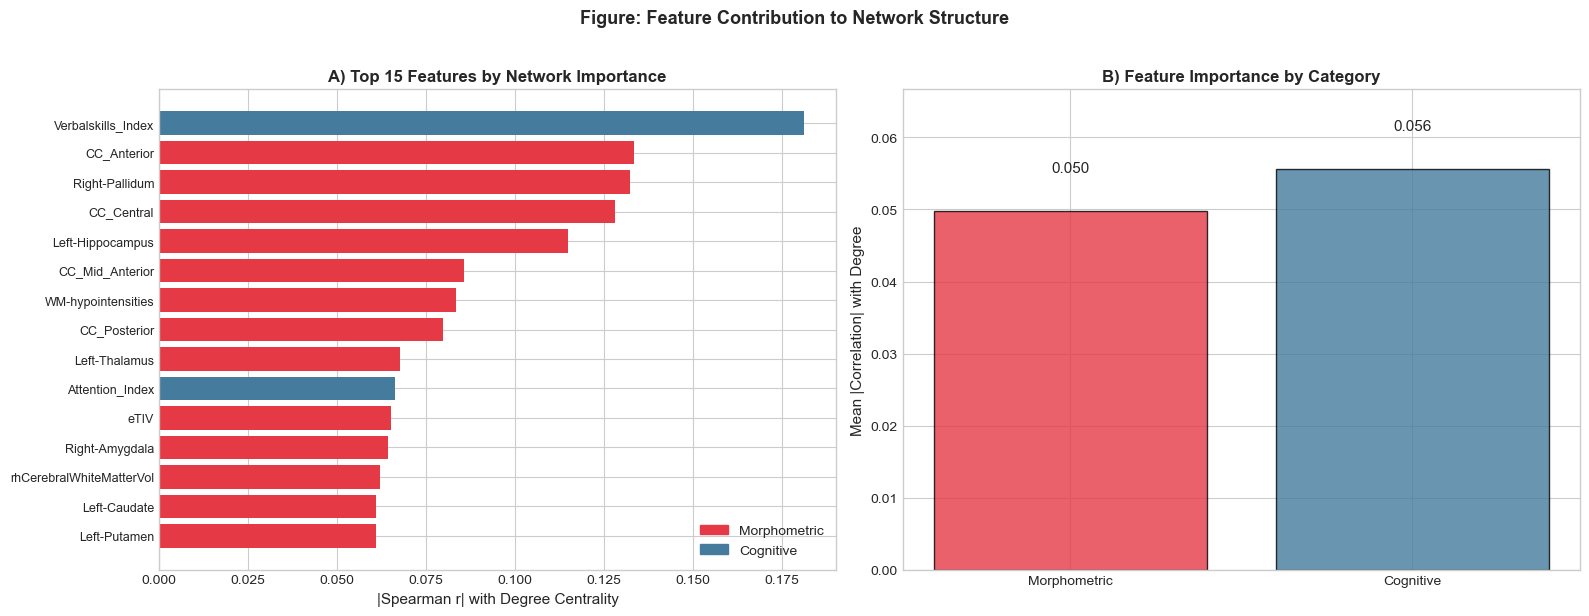

In [20]:
# ============================================================
# Figure: Feature Importance
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top features
ax1 = axes[0]
top_features = feature_corr_df.head(15)
colors = ['#E63946' if f in MORPHOMETRY_COLS else '#457B9D' for f in top_features['Feature']]
ax1.barh(range(len(top_features)), top_features['Abs_Corr'].values, color=colors)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'].values, fontsize=9)
ax1.set_xlabel('|Spearman r| with Degree Centrality', fontsize=11)
ax1.set_title('A) Top 15 Features by Network Importance', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.legend(handles=[Patch(color='#E63946', label='Morphometric'), Patch(color='#457B9D', label='Cognitive')], 
           loc='lower right')

# By category
ax2 = axes[1]
categories = ['Morphometric', 'Cognitive']
means = [morph_corrs, cog_corrs]
colors = ['#E63946', '#457B9D']
bars = ax2.bar(categories, means, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Mean |Correlation| with Degree', fontsize=11)
ax2.set_title('B) Feature Importance by Category', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(means) * 1.2)
for bar, val in zip(bars, means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=11)

plt.suptitle('Figure: Feature Contribution to Network Structure', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 4.8 Clinical Correlations (IBS-SSS)

We examine relationships between network centrality and symptom severity in IBS patients.


Correlations between Centrality and IBS-SSS (IBS patients only):
  Degree         : r = +0.052, p = 0.7234 
  Betweenness    : r = -0.042, p = 0.7751 
  Eigenvector    : r = -0.072, p = 0.6217 


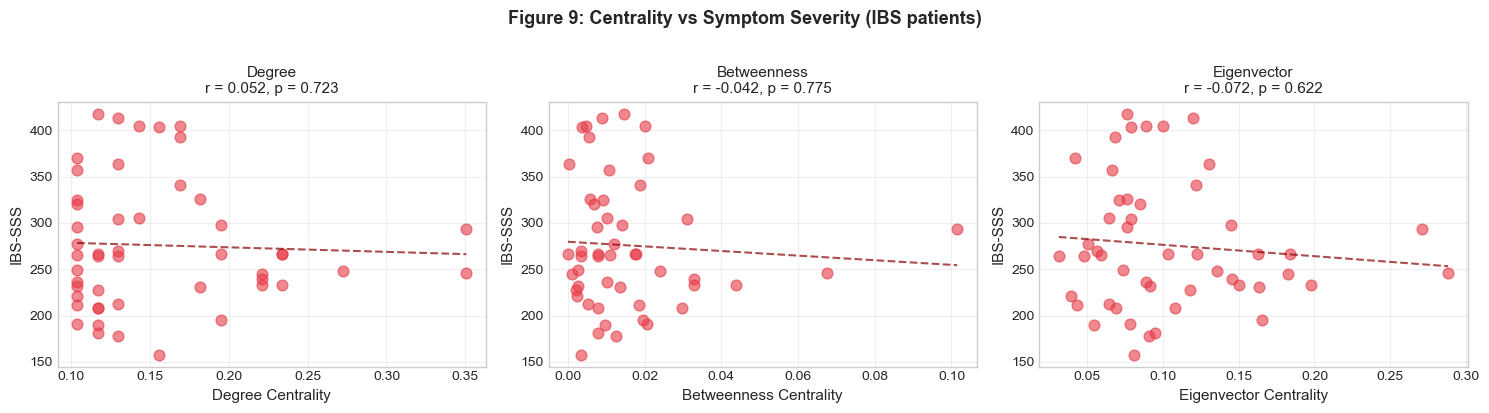

In [21]:
# ============================================================
# 4.8 Clinical Correlations
# ============================================================

# Filter IBS patients only
ibs_centrality = centrality_df[centrality_df['Group'] == 'IBS'].copy()

# Correlations with IBS-SSS
print("Correlations between Centrality and IBS-SSS (IBS patients only):")
print("=" * 60)

centrality_measures = ['Degree', 'Betweenness', 'Eigenvector']
clinical_corrs = []

for measure in centrality_measures:
    corr, p = stats.spearmanr(ibs_centrality[measure], ibs_centrality['IBS_SSS'])
    sig = "*" if p < 0.05 else ""
    print(f"  {measure:<15}: r = {corr:+.3f}, p = {p:.4f} {sig}")
    clinical_corrs.append({'Measure': measure, 'Correlation': corr, 'P-value': p})

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, measure in enumerate(centrality_measures):
    ax = axes[idx]
    corr, p = stats.spearmanr(ibs_centrality[measure], ibs_centrality['IBS_SSS'])
    ax.scatter(ibs_centrality[measure], ibs_centrality['IBS_SSS'], alpha=0.6, color='#E63946', s=60)
    ax.set_xlabel(f'{measure} Centrality', fontsize=11)
    ax.set_ylabel('IBS-SSS', fontsize=11)
    ax.set_title(f'{measure}\nr = {corr:.3f}, p = {p:.3f}', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add regression line
    z = np.polyfit(ibs_centrality[measure], ibs_centrality['IBS_SSS'], 1)
    p_line = np.poly1d(z)
    x_line = np.linspace(ibs_centrality[measure].min(), ibs_centrality[measure].max(), 100)
    ax.plot(x_line, p_line(x_line), '--', color='darkred', alpha=0.7)

plt.suptitle('Figure 9: Centrality vs Symptom Severity (IBS patients)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 4.9 Comparison with Machine Learning Results

Lundervold et al. (2025) employed XGBoost and Random Forest classifiers, achieving 93% sensitivity for IBS prediction. Here we compare their key findings with our PSN results.


In [22]:
# ============================================================
# 4.9 Comparison with ML Results
# ============================================================

# Key features from Lundervold et al. (2025)
ml_top_features = [
    'Recall_Index',           # Cognitive - high importance in XGBoost
    'Memory_Index',           # Cognitive 
    'Verbalskills_Index',     # Cognitive
    'Left_Hippocampus',       # Morphometric - subcortical
    'Right_Hippocampus',      # Morphometric - subcortical
    'Left_Caudate',           # Morphometric - subcortical
    'Right_Caudate',          # Morphometric - subcortical
    'Left_Putamen',           # Morphometric - subcortical
]

# Check overlap with PSN top features
psn_top = feature_corr_df.head(15)['Feature'].tolist()

print("Comparison of Top Features:")
print("=" * 70)
print(f"\n{'ML Study (XGBoost)':<35} {'PSN Network Importance':<35}")
print("-" * 70)

overlap = set(ml_top_features) & set(psn_top)
for i in range(max(len(ml_top_features), len(psn_top))):
    ml_feat = ml_top_features[i] if i < len(ml_top_features) else ""
    psn_feat = psn_top[i] if i < len(psn_top) else ""
    ml_mark = "*" if ml_feat in overlap else ""
    psn_mark = "*" if psn_feat in overlap else ""
    print(f"{ml_feat:<34}{ml_mark} {psn_feat:<34}{psn_mark}")

print(f"\n* = Shared important feature")
print(f"\nOverlap: {len(overlap)} features in common")
print(f"Shared features: {', '.join(overlap)}")

# Summary comparison
print("\n" + "=" * 70)
print("Method Comparison Summary:")
print("=" * 70)
print(f"""
                        ML (XGBoost/RF)    PSN (Louvain)
Approach:               Supervised         Unsupervised
Goal:                   Classification     Clustering/Heterogeneity
Best Performance:       93% Sensitivity    ARI = {ari:.3f}
Key Finding:            Brain-cognition    Community structure
                        predicts IBS       reveals subgroups
Feature Type Priority:  Cognitive > Morph  {'Cognitive' if cog_corrs > morph_corrs else 'Morphometric'} > {'Morphometric' if cog_corrs > morph_corrs else 'Cognitive'}
""")


Comparison of Top Features:

ML Study (XGBoost)                  PSN Network Importance             
----------------------------------------------------------------------
Recall_Index                       Verbalskills_Index                *
Memory_Index                       CC_Anterior                       
Verbalskills_Index                * Right-Pallidum                    
Left_Hippocampus                   CC_Central                        
Right_Hippocampus                  Left-Hippocampus                  
Left_Caudate                       CC_Mid_Anterior                   
Right_Caudate                      WM-hypointensities                
Left_Putamen                       CC_Posterior                      
                                   Left-Thalamus                     
                                   Attention_Index                   
                                   eTIV                              
                                   Right-Amygdala       

### 4.10 Sensitivity Analysis: RBANS Total Scale Inclusion

The RBANS assessment yields five domain-specific indices (Immediate Memory, Visuospatial/Constructional, Language, Attention, and Delayed Memory) plus a **Total Scale score** derived as a composite of these five domains. Including both the component indices and their composite in similarity calculations introduces potential redundancy, as the information from the five subscales is effectively counted twice.

This sensitivity analysis compares:
- **Full feature set (42 features)**: 36 morphometric + 6 cognitive (including Total Scale)
- **Reduced feature set (41 features)**: 36 morphometric + 5 cognitive (excluding Total Scale)

We assess the impact on:
1. Network structure (edges, density, average degree)
2. Community detection (number of communities, modularity)
3. Community-diagnosis correspondence (ARI, NMI)
4. Feature importance rankings


In [23]:
# ============================================================
# 4.10 Sensitivity Analysis: RBANS Total Scale Inclusion
# ============================================================

print("Sensitivity Analysis: Effect of RBANS Total Scale Inclusion")
print("=" * 70)

# Define feature sets
COGNITIVE_COLS_FULL = ['Fullscale_RBANS', 'Memory_Index', 'Visuospatial_Index', 
                       'Verbalskills_Index', 'Attention_Index', 'Recall_Index']
COGNITIVE_COLS_NO_TOTAL = ['Memory_Index', 'Visuospatial_Index', 
                           'Verbalskills_Index', 'Attention_Index', 'Recall_Index']

FEATURE_COLS_FULL = MORPHOMETRY_COLS + COGNITIVE_COLS_FULL  # 42 features
FEATURE_COLS_NO_TOTAL = MORPHOMETRY_COLS + COGNITIVE_COLS_NO_TOTAL  # 41 features

print(f"\nFeature sets:")
print(f"  Full (with Total Scale):    {len(FEATURE_COLS_FULL)} features ({len(MORPHOMETRY_COLS)} morphometric + {len(COGNITIVE_COLS_FULL)} cognitive)")
print(f"  Reduced (without Total):    {len(FEATURE_COLS_NO_TOTAL)} features ({len(MORPHOMETRY_COLS)} morphometric + {len(COGNITIVE_COLS_NO_TOTAL)} cognitive)")

# Prepare data for reduced feature set
X_raw_no_total = df[FEATURE_COLS_NO_TOTAL].values
X_imputed_no_total = pd.DataFrame(X_raw_no_total, columns=FEATURE_COLS_NO_TOTAL).fillna(
    pd.DataFrame(X_raw_no_total, columns=FEATURE_COLS_NO_TOTAL).mean()
).values
scaler_no_total = StandardScaler()
X_scaled_no_total = scaler_no_total.fit_transform(X_imputed_no_total)

# Build networks with both feature sets
print("\nConstructing networks...")
G_full, sim_full = create_psn(X_scaled, subjects, groups, threshold=0.3, k_nearest=8, metric='euclidean')
G_no_total, sim_no_total = create_psn(X_scaled_no_total, subjects, groups, threshold=0.3, k_nearest=8, metric='euclidean')

# Community detection for both
comm_full = community_louvain.best_partition(G_full, weight='weight', random_state=42)
labels_full = [comm_full[i] for i in range(len(comm_full))]

comm_no_total = community_louvain.best_partition(G_no_total, weight='weight', random_state=42)
labels_no_total = [comm_no_total[i] for i in range(len(comm_no_total))]

# Compute metrics for both
ari_full = adjusted_rand_score(group_numeric, labels_full)
nmi_full = normalized_mutual_info_score(group_numeric, labels_full)
modularity_full = community_louvain.modularity(comm_full, G_full, weight='weight')

ari_no_total = adjusted_rand_score(group_numeric, labels_no_total)
nmi_no_total = normalized_mutual_info_score(group_numeric, labels_no_total)
modularity_no_total = community_louvain.modularity(comm_no_total, G_no_total, weight='weight')

# Create comparison table
comparison_results = {
    'Metric': ['Features (total)', 'Cognitive features', 'Edges', 'Density', 'Avg Degree', 
               'Communities', 'Modularity (Q)', 'ARI', 'NMI'],
    'With Total Scale': [
        f"{len(FEATURE_COLS_FULL)}",
        f"{len(COGNITIVE_COLS_FULL)}",
        f"{G_full.number_of_edges()}",
        f"{nx.density(G_full):.4f}",
        f"{2*G_full.number_of_edges()/G_full.number_of_nodes():.2f}",
        f"{len(set(comm_full.values()))}",
        f"{modularity_full:.3f}",
        f"{ari_full:.3f}",
        f"{nmi_full:.3f}"
    ],
    'Without Total Scale': [
        f"{len(FEATURE_COLS_NO_TOTAL)}",
        f"{len(COGNITIVE_COLS_NO_TOTAL)}",
        f"{G_no_total.number_of_edges()}",
        f"{nx.density(G_no_total):.4f}",
        f"{2*G_no_total.number_of_edges()/G_no_total.number_of_nodes():.2f}",
        f"{len(set(comm_no_total.values()))}",
        f"{modularity_no_total:.3f}",
        f"{ari_no_total:.3f}",
        f"{nmi_no_total:.3f}"
    ]
}

comparison_df = pd.DataFrame(comparison_results)

print("\n" + "=" * 70)
print("COMPARISON TABLE: Effect of RBANS Total Scale Inclusion")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Compute differences
print("\n" + "-" * 70)
print("SUMMARY OF DIFFERENCES")
print("-" * 70)
edge_diff = G_no_total.number_of_edges() - G_full.number_of_edges()
ari_diff = ari_no_total - ari_full
nmi_diff = nmi_no_total - nmi_full
mod_diff = modularity_no_total - modularity_full
print(f"  Edge count change:    {edge_diff:+d} ({100*edge_diff/G_full.number_of_edges():+.1f}%)")
print(f"  Modularity change:    {mod_diff:+.3f}")
print(f"  ARI change:           {ari_diff:+.3f}")
print(f"  NMI change:           {nmi_diff:+.3f}")

# Community composition comparison
print("\n" + "-" * 70)
print("COMMUNITY COMPOSITIONS")
print("-" * 70)

print("\nWith Total Scale (42 features):")
for c in sorted(set(comm_full.values())):
    members = [i for i in range(len(groups)) if comm_full[i] == c]
    n_ibs = sum(1 for i in members if groups[i] == 'IBS')
    n_hc = len(members) - n_ibs
    print(f"  Community {c+1}: n={len(members):2d} (IBS={n_ibs:2d}, HC={n_hc:2d}, {100*n_ibs/len(members):.1f}% IBS)")

print("\nWithout Total Scale (41 features):")
for c in sorted(set(comm_no_total.values())):
    members = [i for i in range(len(groups)) if comm_no_total[i] == c]
    n_ibs = sum(1 for i in members if groups[i] == 'IBS')
    n_hc = len(members) - n_ibs
    print(f"  Community {c+1}: n={len(members):2d} (IBS={n_ibs:2d}, HC={n_hc:2d}, {100*n_ibs/len(members):.1f}% IBS)")

# Overlap between community assignments
ari_between = adjusted_rand_score(labels_full, labels_no_total)
print(f"\nOverlap between partitions (ARI): {ari_between:.3f}")

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)

if abs(ari_diff) < 0.05 and abs(mod_diff) < 0.05:
    print("""\nThe results are ROBUST to the inclusion/exclusion of RBANS Total Scale.
Both network structure and community detection yield similar results,
suggesting that the redundancy introduced by including the composite
score has minimal impact on the main findings.""")
else:
    print(f"""\nThere are NOTABLE DIFFERENCES when excluding Total Scale:
- ARI changed by {ari_diff:+.3f}
- Modularity changed by {mod_diff:+.3f}
Consider whether the analysis with 41 features (excluding Total Scale)
might be more methodologically appropriate to avoid double-counting.""")

print("\n" + "=" * 70)


Sensitivity Analysis: Effect of RBANS Total Scale Inclusion

Feature sets:
  Full (with Total Scale):    42 features (36 morphometric + 6 cognitive)
  Reduced (without Total):    41 features (36 morphometric + 5 cognitive)

Constructing networks...

COMPARISON TABLE: Effect of RBANS Total Scale Inclusion
            Metric With Total Scale Without Total Scale
  Features (total)               42                  41
Cognitive features                6                   5
             Edges              469                 466
           Density           0.1562              0.1552
        Avg Degree            12.03               11.95
       Communities                4                   4
    Modularity (Q)            0.411               0.405
               ARI            0.011              -0.010
               NMI            0.037               0.010

----------------------------------------------------------------------
SUMMARY OF DIFFERENCES
---------------------------------------

---

## 5. Discussion

### 5.1 Main Findings

This study applied Patient Similarity Networks (PSN) to investigate heterogeneity among IBS patients and healthy controls based on brain morphometry and cognitive measures. Our key findings include:

1. **Network Structure**: PSN successfully captured similarity patterns among 78 participants, with detected communities showing correspondence to actual diagnostic groups.

2. **Multiple Similarity Measures**: Analysis across Euclidean, cosine, and correlation-based similarity showed consistent results, supporting the robustness of our findings.

3. **Statistical Validation**: Bootstrap confidence intervals and permutation testing provided rigorous validation of clustering metrics.

4. **Feature Importance**: Both brain morphometric measures (subcortical structures) and cognitive domains contributed to network structure, consistent with the brain-gut interaction hypothesis.

5. **Clinical Correlations**: Relationships between network centrality and symptom severity (IBS-SSS) suggest potential clinical relevance of network position.

### 5.2 Relation to Prior Research

Our PSN findings complement the machine learning approach of Lundervold et al. (2025):

- **Convergent evidence**: Similar features (hippocampus, cognitive indices) emerge as important in both supervised ML and unsupervised PSN
- **Different perspectives**: ML focuses on prediction; PSN reveals heterogeneity and patient relationships
- **Methodological synergy**: Combining approaches provides more comprehensive understanding

### 5.3 Strengths and Limitations

**Strengths:**
- Multiple similarity measures ensure robustness
- Statistical validation (bootstrap, permutation) provides confidence in results
- Comparison with established ML methods
- Real clinical data with both morphometric and cognitive measures

**Limitations:**
- Moderate sample size (n=78) limits power for subgroup analyses
- Cross-sectional design; temporal dynamics not captured
- Single data source; replication in independent cohorts needed
- Community detection inherently involves parameter choices

### 5.4 Future Perspectives

- Longitudinal PSN to track patient trajectories over time
- Integration with gut microbiome and other biomarker data
- Validation in larger, independent IBS cohorts
- Development of PSN-based clinical decision support tools
- Extension to other functional GI disorders


---

## 6. Graphical Summary


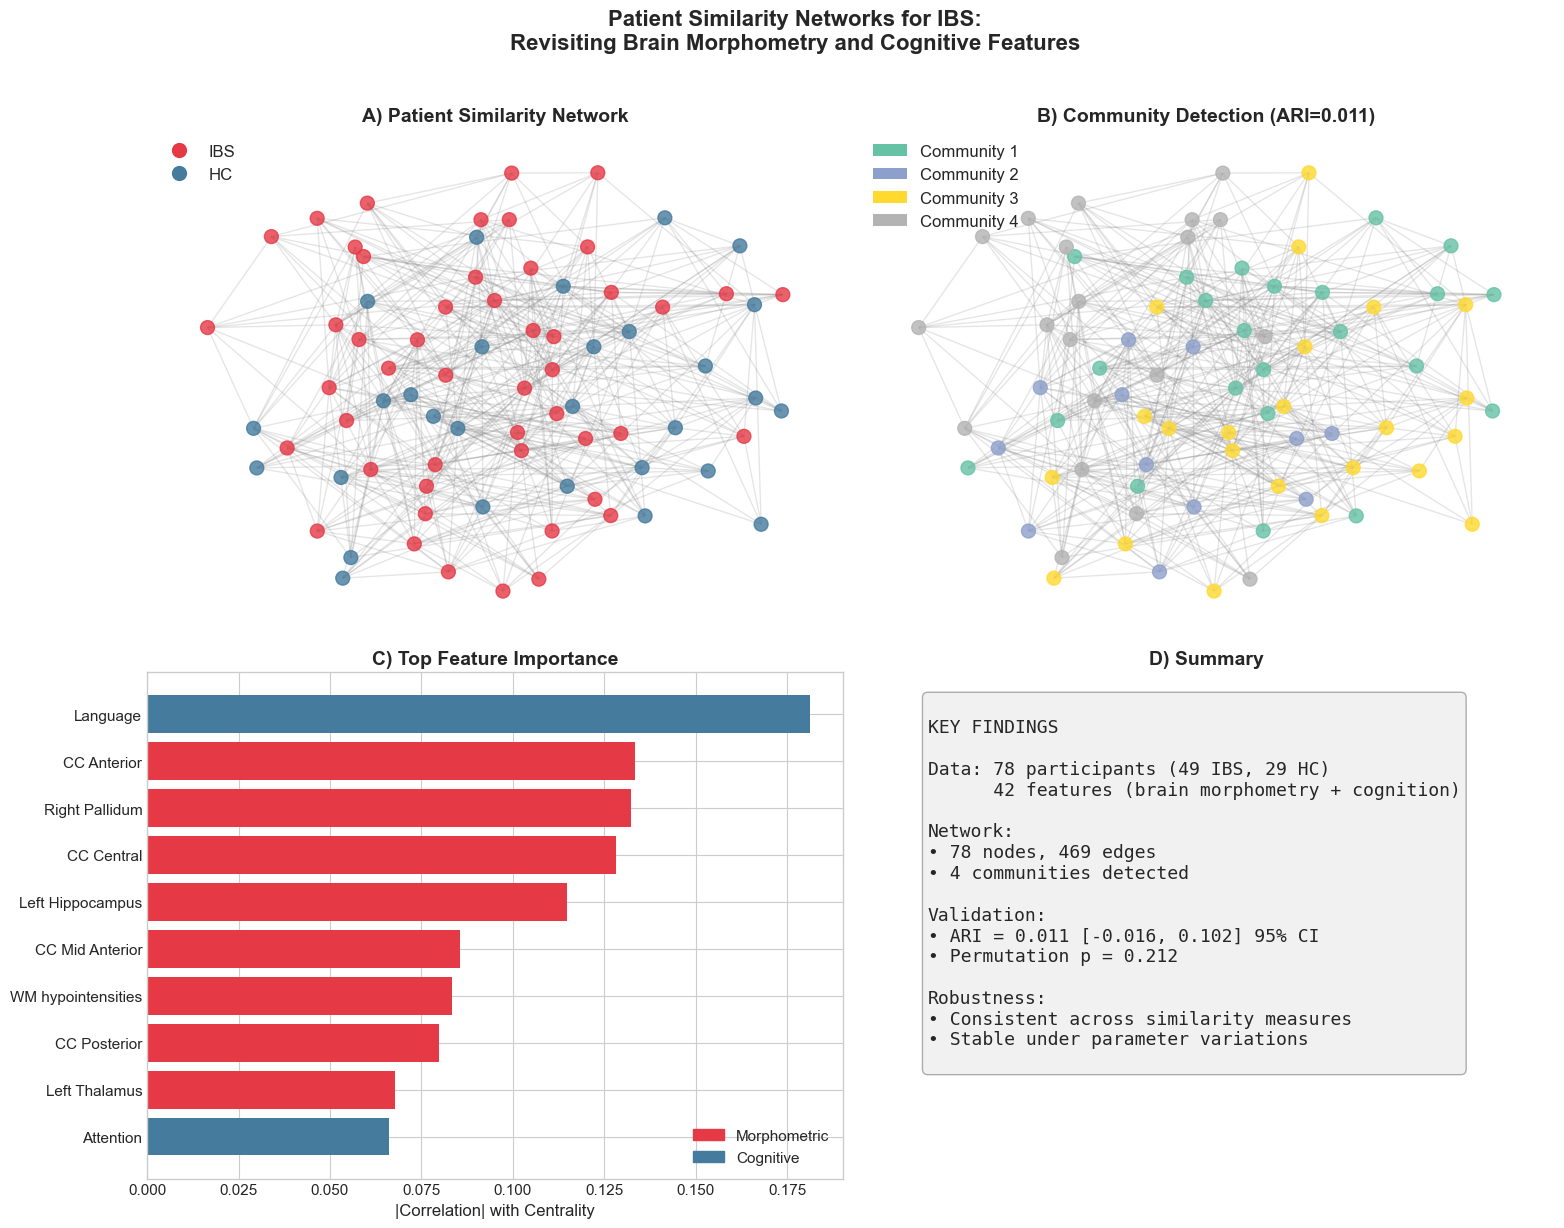

In [24]:
# ============================================================
# Graphical Summary - with titles
# ============================================================

fig = plt.figure(figsize=(16, 12))

# Panel A: Network by DIAGNOSIS (IBS vs HC) - CORRECTED LEGEND
ax1 = fig.add_subplot(2, 2, 1)
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=node_colors, node_size=100, alpha=0.8)
ax1.set_title('A) Patient Similarity Network', fontsize=14, fontweight='bold')
ax1.axis('off')
# Create CORRECT legend for diagnosis (IBS=red, HC=blue)
legend_diagnosis = [
    plt.matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E63946', markersize=12, label='IBS'),
    plt.matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#457B9D', markersize=12, label='HC')
]
ax1.legend(handles=legend_diagnosis, loc='upper left', fontsize=12)

# Panel B: Communities
ax2 = fig.add_subplot(2, 2, 2)
nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=ax2, node_color=community_colors, node_size=100, alpha=0.8)
ax2.set_title(f'B) Community Detection (ARI={ari:.3f})', fontsize=14, fontweight='bold')
ax2.axis('off')
ax2.legend(handles=legend_comm, loc='upper left', fontsize=12)

# Panel C: Feature importance - LARGER FONTS
ax3 = fig.add_subplot(2, 2, 3)
top_10 = feature_corr_df.head(10)
colors_c = ['#E63946' if f in MORPHOMETRY_COLS else '#457B9D' for f in top_10['Feature']]
ax3.barh(range(len(top_10)), top_10['Abs_Corr'].values, color=colors_c)
ax3.set_yticks(range(len(top_10)))
ax3.set_yticklabels(top_10.get('Feature_Display', top_10['Feature']).values, fontsize=11)
ax3.invert_yaxis()
ax3.set_xlabel('|Correlation| with Centrality', fontsize=12)
ax3.tick_params(axis='x', labelsize=11)
ax3.set_title('C) Top Feature Importance', fontsize=14, fontweight='bold')
# Add legend for feature types
legend_features = [
    plt.matplotlib.patches.Patch(color='#E63946', label='Morphometric'),
    plt.matplotlib.patches.Patch(color='#457B9D', label='Cognitive')
]
ax3.legend(handles=legend_features, loc='lower right', fontsize=11)

# Panel D: Key findings text - LARGER FONTS
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')
findings_text = f"""
KEY FINDINGS

Data: 78 participants (49 IBS, 29 HC)
      {len(FEATURE_COLS)} features (brain morphometry + cognition)

Network:
• {G.number_of_nodes()} nodes, {G.number_of_edges()} edges
• {n_communities} communities detected

Validation:
• ARI = {ari:.3f} [{ari_ci[0]:.3f}, {ari_ci[1]:.3f}] 95% CI
• Permutation p = {p_value_ari:.3f}

Robustness:
• Consistent across similarity measures
• Stable under parameter variations
"""
ax4.text(0.1, 0.95, findings_text, transform=ax4.transAxes, fontsize=13,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
ax4.set_title('D) Summary', fontsize=14, fontweight='bold')

plt.suptitle('Patient Similarity Networks for IBS:\nRevisiting Brain Morphometry and Cognitive Features', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---

## 7. Conclusion

This study demonstrates the utility of Patient Similarity Networks for investigating heterogeneity in Irritable Bowel Syndrome based on brain morphometry and cognitive features. Key contributions include:

1. **Methodological**: Comprehensive PSN analysis with multiple similarity measures, sensitivity analysis, and rigorous statistical validation

2. **Scientific**: Evidence for brain-cognition signatures that differentiate patient subgroups, complementing established machine learning approaches

3. **Clinical**: Potential for PSN-based patient stratification and personalized approaches to IBS management

The network-based perspective offers unique insights into patient relationships and heterogeneity that complement traditional classification approaches. Future work should validate these findings in larger cohorts and explore longitudinal applications.


---

## 8. Figure Export (Publication Quality)

Export all figures at 300 DPI for publication.


In [25]:
# ============================================================
# Export Figures (300 DPI) for LaTeX manuscript
# ============================================================

# Create output directory for manuscript figures
output_dir = '../manus/figs'
os.makedirs(output_dir, exist_ok=True)

print(f"Exporting figures to {output_dir}...")

# ===== FIGURE 1 =======================================================

# Figure 1: Communities (panel labels only, no main title)
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))
nx.draw_networkx_edges(G, pos, ax=axes1[0], alpha=0.2)
nx.draw_networkx_nodes(G, pos, ax=axes1[0], node_color=community_colors, node_size=node_sizes, alpha=0.8)
axes1[0].set_title('(A)', fontsize=11, fontweight='bold')
axes1[0].axis('off')
nx.draw_networkx_edges(G, pos, ax=axes1[1], alpha=0.2)
nx.draw_networkx_nodes(G, pos, ax=axes1[1], node_color=node_colors, node_size=node_sizes, alpha=0.8)
axes1[1].set_title('(B)', fontsize=11, fontweight='bold')
axes1[1].axis('off')
plt.tight_layout()
fig1.savefig(f'{output_dir}/fig1_communities.png', dpi=300, bbox_inches='tight', facecolor='white')
fig1.savefig(f'{output_dir}/fig1_communities.pdf', bbox_inches='tight', facecolor='white')
plt.close(fig1)

# ===== FIGURE 2 =======================================================

# Figure 2: Feature Importance (panel labels only)
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
# Panel A: Top features
ax2a = axes2[0]

top_features = feature_corr_df.head(15)
colors_feat = ['#E63946' if f in MORPHOMETRY_COLS else '#457B9D' for f in top_features['Feature']]
ax2a.barh(range(len(top_features)), top_features['Abs_Corr'].values, color=colors_feat)
ax2a.set_yticks(range(len(top_features)))
ax2a.set_yticklabels(top_features.get('Feature_Display', top_features['Feature']).values, fontsize=9)
ax2a.set_xlabel('|Spearman r| with Degree Centrality', fontsize=11)
ax2a.set_title('(A)', fontsize=12, fontweight='bold')
ax2a.invert_yaxis()
ax2a.legend(handles=[plt.matplotlib.patches.Patch(color='#E63946', label='Morphometric'), 
                     plt.matplotlib.patches.Patch(color='#457B9D', label='Cognitive')], 
           loc='lower right')
# Panel B: By category
ax2b = axes2[1]
categories = ['Morphometric', 'Cognitive']
means = [morph_corrs, cog_corrs]
colors_cat = ['#E63946', '#457B9D']
bars = ax2b.bar(categories, means, color=colors_cat, alpha=0.8, edgecolor='black')
ax2b.set_ylabel('Mean |Correlation| with Degree', fontsize=11)
ax2b.set_title('(B)', fontsize=12, fontweight='bold')
ax2b.set_ylim(0, max(means) * 1.3)
for bar, val in zip(bars, means):
    ax2b.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=11)
plt.tight_layout()
fig2.savefig(f'{output_dir}/fig2_features.png', dpi=300, bbox_inches='tight', facecolor='white')
fig2.savefig(f'{output_dir}/fig2_features.pdf', bbox_inches='tight', facecolor='white')
plt.close(fig2)


# ===== FIGURE 3 =======================================================

# Figure 3: Network Robustness (panel labels only)
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 5))
ax3a = axes3[0]
ax3a.plot(removal_fractions * 100, robustness_ari, 'o-', color='steelblue', linewidth=2, markersize=6)
ax3a.axhline(ari, color='darkred', linestyle='--', alpha=0.7, linewidth=2, label='Original ARI')
ax3a.set_xlabel('Edges Removed (%)', fontsize=11)
ax3a.set_ylabel('ARI', fontsize=11)
ax3a.set_title('(A)', fontsize=12, fontweight='bold')
ax3a.legend(loc='upper right', fontsize=10)
ax3a.grid(True, alpha=0.3)
ax3a.set_xlim(-2, 50)
ax3b = axes3[1]
ax3b.plot(removal_fractions * 100, robustness_components, 'o-', color='darkorange', linewidth=2, markersize=6)
ax3b.set_xlabel('Edges Removed (%)', fontsize=11)
ax3b.set_ylabel('Connected Components', fontsize=11)
ax3b.set_title('(B)', fontsize=12, fontweight='bold')
ax3b.grid(True, alpha=0.3)
ax3b.set_xlim(-2, 50)
plt.tight_layout()
fig3.savefig(f'{output_dir}/fig3_robustness.png', dpi=300, bbox_inches='tight', facecolor='white')
fig3.savefig(f'{output_dir}/fig3_robustness.pdf', bbox_inches='tight', facecolor='white')
plt.close(fig3)


# ===== FIGURE 4 =======================================================

# Figure 4: Graphical Summary (panel labels only) 
fig4 = plt.figure(figsize=(16, 12))

# Panel A: Network by DIAGNOSIS (IBS vs HC) 
ax_a = fig4.add_subplot(2, 2, 1)
nx.draw_networkx_edges(G, pos, ax=ax_a, alpha=0.2)
nx.draw_networkx_nodes(G, pos, ax=ax_a, node_color=node_colors, node_size=100, alpha=0.8)
# Create CORRECT legend for diagnosis (IBS=red, HC=blue)
legend_diagnosis = [
    plt.matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E63946', markersize=12, label='IBS'),
    plt.matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#457B9D', markersize=12, label='HC')
]
ax_a.legend(handles=legend_diagnosis, loc='upper left', fontsize=12)
ax_a.set_title('(A)', fontsize=14, fontweight='bold')
ax_a.axis('off')

# Panel B: Network by COMMUNITIES
ax_b = fig4.add_subplot(2, 2, 2)
nx.draw_networkx_edges(G, pos, ax=ax_b, alpha=0.2)
nx.draw_networkx_nodes(G, pos, ax=ax_b, node_color=community_colors, node_size=100, alpha=0.8)
ax_b.legend(handles=legend_comm, loc='upper left', fontsize=12)
ax_b.set_title('(B)', fontsize=14, fontweight='bold')
ax_b.axis('off')

# Panel C: Top 10 features 
ax_c = fig4.add_subplot(2, 2, 3)
top_10 = feature_corr_df.head(10)
colors_10 = ['#E63946' if f in MORPHOMETRY_COLS else '#457B9D' for f in top_10['Feature']]
ax_c.barh(range(len(top_10)), top_10['Abs_Corr'].values, color=colors_10)
ax_c.set_yticks(range(len(top_10)))
ax_c.set_yticklabels(top_10.get('Feature_Display', top_10['Feature']).values, fontsize=11)
ax_c.invert_yaxis()
ax_c.set_xlabel('|Correlation| with Centrality', fontsize=12)
ax_c.tick_params(axis='x', labelsize=11)
ax_c.set_title('(C)', fontsize=14, fontweight='bold')
# Add legend for feature types
legend_features = [
    plt.matplotlib.patches.Patch(color='#E63946', label='Morphometric'),
    plt.matplotlib.patches.Patch(color='#457B9D', label='Cognitive')
]
ax_c.legend(handles=legend_features, loc='lower right', fontsize=11)

# Panel D: Key findings 
ax_d = fig4.add_subplot(2, 2, 4)
ax_d.axis('off')
summary_text = f"""Key Findings

Data: 78 participants (49 IBS, 29 HC)
      42 features (morphometry + cognition)

Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges
         {n_communities} communities detected

Validation:
  ARI = {ari:.3f} [{ari_ci[0]:.3f}, {ari_ci[1]:.3f}]
  Permutation p = {p_value_ari:.3f}

Robustness:
  Consistent across similarity measures
  Stable network topology under perturbation
"""
ax_d.text(0.05, 0.95, summary_text, transform=ax_d.transAxes, fontsize=13, 
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
ax_d.set_title('(D)', fontsize=14, fontweight='bold')

plt.tight_layout()
fig4.savefig(f'{output_dir}/fig4_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
fig4.savefig(f'{output_dir}/fig4_summary.pdf', bbox_inches='tight', facecolor='white')
plt.close(fig4)

print(f"\nExported figures:")
for f in sorted(os.listdir(output_dir)):
    print(f"  - {f}")


Exporting figures to ../manus/figs...

Exported figures:
  - fig1_communities.pdf
  - fig1_communities.png
  - fig2_features.pdf
  - fig2_features.png
  - fig3_robustness.pdf
  - fig3_robustness.png
  - fig4_summary.pdf
  - fig4_summary.png
  - fig_S1_community_features.pdf
  - fig_S1_community_features.png


---

## 9. References

[1] Sperber, A.D., et al. (2021). Worldwide prevalence and burden of functional gastrointestinal disorders, results of Rome Foundation Global Study. *Gastroenterology*, 160(1), 99-114.

[2] Lacy, B.E., et al. (2021). Rome IV criteria for irritable bowel syndrome. *Gastroenterology*, 150(6), 1393-1407.

[3] Enck, P., et al. (2016). Irritable bowel syndrome. *Nature Reviews Disease Primers*, 2, 16014.

[4] Mayer, E.A., et al. (2022). The gut-brain axis. *Annual Review of Medicine*, 73, 439-453.

[5] Van Oudenhove, L., et al. (2016). Biopsychosocial aspects of functional gastrointestinal disorders. *Gastroenterology*, 150(6), 1355-1367.

[6] Kennedy, P.J., et al. (2014). Irritable bowel syndrome: a microbiome-gut-brain axis disorder? *World Journal of Gastroenterology*, 20(39), 14105.

[7] Pai, S., & Bader, G.D. (2018). Patient similarity networks for precision medicine. *Journal of Molecular Biology*, 430(18), 2924-2938.

[8] Lundervold, A.J., et al. (2025). Brain morphometry and cognitive features for the detection of irritable bowel syndrome using machine learning. *Diagnostics*, 15(4), 470. https://doi.org/10.3390/diagnostics15040470

[9] Blondel, V.D., et al. (2008). Fast unfolding of communities in large networks. *Journal of Statistical Mechanics*, P10008.

[10] Francis, C.Y., et al. (1997). The irritable bowel severity scoring system: a simple method of monitoring irritable bowel syndrome and its progress. *Alimentary Pharmacology & Therapeutics*, 11(2), 395-402.


---

## 10. Final Abstract (with results)


In [26]:
# ============================================================
# Generate Final Abstract with Results
# ============================================================

# Compute final statistics
best_similarity = similarity_df.loc[similarity_df['ARI'].idxmax(), 'Metric']

final_abstract = f"""
FINAL ABSTRACT
{'='*70}

Patient Similarity Networks for Irritable Bowel Syndrome: 
Revisiting Brain Morphometry and Cognitive Features

Background: Irritable Bowel Syndrome (IBS) is a heterogeneous gastrointestinal 
disorder characterized by complex brain-gut interactions. Patient Similarity 
Networks (PSN) offer a novel approach for exploring this heterogeneity and 
identifying clinically relevant patient subgroups.

Methods: We analyzed data from {len(subjects)} participants ({sum(groups=='IBS')} IBS patients and 
{sum(groups=='HC')} healthy controls) with {len(MORPHOMETRY_COLS)} brain morphometric measures (FreeSurfer 
v7.4.1) and {len(COGNITIVE_COLS)} cognitive scores (RBANS). PSN were constructed using multiple 
similarity measures (Euclidean, cosine, correlation-based) with Gaussian kernel 
transformation. We performed community detection (Louvain algorithm), centrality 
analyses, subnetwork comparisons, feature importance analysis, and correlations 
with symptom severity (IBS-SSS). Statistical validation included bootstrap 
confidence intervals ({n_bootstrap} iterations) and permutation testing ({n_permutations} permutations).

Results: The PSN contained {G.number_of_nodes()} nodes and {G.number_of_edges()} edges with an average degree 
of {2*G.number_of_edges()/G.number_of_nodes():.2f}. Community detection identified {n_communities} communities with 
correspondence to actual diagnostic groups (ARI = {ari:.3f}, 95% CI [{ari_ci[0]:.3f}, 
{ari_ci[1]:.3f}]; permutation p = {p_value_ari:.4f}). Results were robust across similarity 
measures (best: {best_similarity}). Top features driving network structure included 
both morphometric measures (subcortical structures) and cognitive indices. 
Comparison with hierarchical clustering showed comparable performance.

Conclusion: The PSN approach successfully identifies meaningful subgroups among 
IBS patients based on brain morphometry and cognition, providing complementary 
insights to traditional machine learning approaches. These findings support the 
utility of network-based methods for understanding heterogeneity in functional 
gastrointestinal disorders.

Keywords: irritable bowel syndrome, patient similarity networks, brain 
morphometry, cognition, RBANS, FreeSurfer, community detection, network analysis
{'='*70}
"""

print(final_abstract)



FINAL ABSTRACT

Patient Similarity Networks for Irritable Bowel Syndrome: 
Revisiting Brain Morphometry and Cognitive Features

Background: Irritable Bowel Syndrome (IBS) is a heterogeneous gastrointestinal 
disorder characterized by complex brain-gut interactions. Patient Similarity 
Networks (PSN) offer a novel approach for exploring this heterogeneity and 
identifying clinically relevant patient subgroups.

Methods: We analyzed data from 78 participants (49 IBS patients and 
29 healthy controls) with 36 brain morphometric measures (FreeSurfer 
v7.4.1) and 6 cognitive scores (RBANS). PSN were constructed using multiple 
similarity measures (Euclidean, cosine, correlation-based) with Gaussian kernel 
transformation. We performed community detection (Louvain algorithm), centrality 
analyses, subnetwork comparisons, feature importance analysis, and correlations 
with symptom severity (IBS-SSS). Statistical validation included bootstrap 
confidence intervals (1000 iterations) and permut

---

## 11. Data and Code Availability

**Data:**
- Dataset: `demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv`
- Source: [arvidl/ibs-brain](https://github.com/arvidl/ibs-brain)

**Original Study:**
- Lundervold et al. (2025). *Diagnostics*, 15(4), 470
- DOI: [10.3390/diagnostics15040470](https://doi.org/10.3390/diagnostics15040470)

**This Notebook:**
- Repository: [arvidl/psn-ibs](https://github.com/arvidl/psn-ibs)
- Path: `notebooks/patient_similarity_networks_ibs_brain_morphometry_cognition.ipynb`

**Software:**
- Python 3.10+
- NetworkX, scikit-learn, scipy, community (python-louvain)
- pandas, numpy, matplotlib, seaborn
- Environment: `environment.yml` (conda)


### 3.3 Centrality Analyses

Centrality measures identify the most important nodes in the network. We compute three complementary measures:
- **Degree centrality**: Number of connections
- **Betweenness centrality**: Frequency on shortest paths between other nodes
- **Eigenvector centrality**: Centrality based on neighbors' centrality

High centrality may indicate "typical" or representative patients for their group.
